# Predcition of Hospital Admission Related to Sinusitis

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to sinusitis.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'sinusitis_date_'+str(i), 'sinusitis_ab_date_'+str(i), 'sinusitis_ab_type_'+str(i),
                   'incdt_sinusitis_date_'+str(i), 'admitted_sinusitis_date_'+str(i), 'sgss_gp_cov_sinusitis_date_'+str(i)]]
    
    #drop rows with no sinusitis reord
    datum = datum[datum['sinusitis_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with sinusitis_i
    datum = datum[datum['sgss_gp_cov_sinusitis_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'sinusitis_date_'+str(i): 'sinusitis_date', 'sinusitis_ab_date_'+str(i): 'sinusitis_ab_date', 
                           'sinusitis_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_sinusitis_date_'+str(i): 'incdt_sinusitis_date', 'incdt_sinusitis_type_'+str(i): 'incdt_sinusitis_type',
                           'admitted_sinusitis_date_'+str(i): 'admitted_sinusitis_date',
                           'sgss_gp_cov_sinusitis_date_'+str(i): 'sgss_gp_cov_sinusitis_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_sinusitis_admitted', 'duration_sinusitis_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + sinusitis_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_sinusitis.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_sinusitis/data_sinusitis_record_cph_sinusitis.txt", "w")
a.write("")
a.writelines(['data_sinusitis_1 #with a record, #with no record: %.0f' % (data['sinusitis_date_1'].notna().sum()), ', %.0f' % (data['sinusitis_date_1'].isna().sum()),
              '\ndata_sinusitis_2 #with a record, #with no record: %.0f' % (data['sinusitis_date_2'].notna().sum()), ', %.0f' % (data['sinusitis_date_2'].isna().sum()),
              '\ndata_sinusitis_3 #with a record, #with no record: %.0f' % (data['sinusitis_date_3'].notna().sum()), ', %.0f' % (data['sinusitis_date_3'].isna().sum()),
              '\ndata_sinusitis_4 #with a record, #with no record: %.0f' % (data['sinusitis_date_4'].notna().sum()), ', %.0f' % (data['sinusitis_date_4'].isna().sum()),
              '\ndata_sinusitis_5 #with a record, #with no record: %.0f' % (data['sinusitis_date_5'].notna().sum()), ', %.0f' % (data['sinusitis_date_5'].isna().sum()),
              '\ndata_sinusitis_6 #with a record, #with no record: %.0f' % (data['sinusitis_date_6'].notna().sum()), ', %.0f' % (data['sinusitis_date_6'].isna().sum()),
              '\ndata_sinusitis_7 #with a record, #with no record: %.0f' % (data['sinusitis_date_7'].notna().sum()), ', %.0f' % (data['sinusitis_date_7'].isna().sum()),
              '\ndata_sinusitis_8 #with a record, #with no record: %.0f' % (data['sinusitis_date_8'].notna().sum()), ', %.0f' % (data['sinusitis_date_8'].isna().sum()),
              '\ndata_sinusitis_9 #with a record, #with no record: %.0f' % (data['sinusitis_date_9'].notna().sum()), ', %.0f' % (data['sinusitis_date_9'].isna().sum()),
              '\ndata_sinusitis_10 #with a record, #with no record: %.0f' % (data['sinusitis_date_10'].notna().sum()), ', %.0f' % (data['sinusitis_date_10'].isna().sum()),
              '\ndata_sinusitis_11 #with a record, #with no record: %.0f' % (data['sinusitis_date_11'].notna().sum()), ', %.0f' % (data['sinusitis_date_11'].isna().sum()),
              '\ndata_sinusitis_12 #with a record, #with no record: %.0f' % (data['sinusitis_date_12'].notna().sum()), ', %.0f' % (data['sinusitis_date_12'].isna().sum()),
              '\ndata_sinusitis_13 #with a record, #with no record: %.0f' % (data['sinusitis_date_13'].notna().sum()), ', %.0f' % (data['sinusitis_date_13'].isna().sum()),
              '\ndata_sinusitis_14 #with a record, #with no record: %.0f' % (data['sinusitis_date_14'].notna().sum()), ', %.0f' % (data['sinusitis_date_14'].isna().sum()),
              '\ndata_sinusitis_15 #with a record, #with no record: %.0f' % (data['sinusitis_date_15'].notna().sum()), ', %.0f' % (data['sinusitis_date_15'].isna().sum()),
              '\ndata_sinusitis_16 #with a record, #with no record: %.0f' % (data['sinusitis_date_16'].notna().sum()), ', %.0f' % (data['sinusitis_date_16'].isna().sum()),
              '\ndata_sinusitis_17 #with a record, #with no record: %.0f' % (data['sinusitis_date_17'].notna().sum()), ', %.0f' % (data['sinusitis_date_17'].isna().sum()),
              '\ndata_sinusitis_18 #with a record, #with no record: %.0f' % (data['sinusitis_date_18'].notna().sum()), ', %.0f' % (data['sinusitis_date_18'].isna().sum()),
              '\ndata_sinusitis_19 #with a record, #with no record: %.0f' % (data['sinusitis_date_19'].notna().sum()), ', %.0f' % (data['sinusitis_date_19'].isna().sum()),
              '\ndata_sinusitis_20 #with a record, #with no record: %.0f' % (data['sinusitis_date_20'].notna().sum()), ', %.0f' % (data['sinusitis_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

0.0     37125
1.0     36843
2.0     32991
3.0     24958
4.0     14979
6.0     12362
7.0      9951
5.0      8335
8.0      7879
9.0      5788
10.0     3353
11.0     1916
12.0     1368
13.0      816
14.0      584
15.0      379
16.0      196
17.0      100
18.0       49
19.0       17
20.0        8
22.0        2
21.0        1
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 20 sinusitiss and concatenate them 
data_sinusitis_1 = proc_infec_data(data,1)
data_sinusitis_2 = proc_infec_data(data,2)
data_sinusitis_3 = proc_infec_data(data,3)
data_sinusitis_4 = proc_infec_data(data,4)
data_sinusitis_5 = proc_infec_data(data,5)
data_sinusitis_6 = proc_infec_data(data,6)
data_sinusitis_7 = proc_infec_data(data,7)
data_sinusitis_8 = proc_infec_data(data,8)
data_sinusitis_9 = proc_infec_data(data,9)
data_sinusitis_10 = proc_infec_data(data,10)
data_sinusitis_11 = proc_infec_data(data,11)
data_sinusitis_12 = proc_infec_data(data,12)
data_sinusitis_13 = proc_infec_data(data,13)
data_sinusitis_14 = proc_infec_data(data,14)
data_sinusitis_15 = proc_infec_data(data,15)
data_sinusitis_16 = proc_infec_data(data,16)
data_sinusitis_17 = proc_infec_data(data,17)
data_sinusitis_18 = proc_infec_data(data,18)
data_sinusitis_19 = proc_infec_data(data,19)
data_sinusitis_20 = proc_infec_data(data,20)

data_sinusitis = pd.concat([data_sinusitis_1, data_sinusitis_2, data_sinusitis_3, data_sinusitis_4, data_sinusitis_5, data_sinusitis_6, data_sinusitis_7, data_sinusitis_8, data_sinusitis_9, data_sinusitis_10, data_sinusitis_11, data_sinusitis_12, data_sinusitis_13, data_sinusitis_14, data_sinusitis_15, data_sinusitis_16, data_sinusitis_17, data_sinusitis_18, data_sinusitis_19, data_sinusitis_20])
data_sinusitis.reset_index(inplace=True, drop=True)
data_sinusitis.shape

(216071, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_sinusitis['sinusitis_date'] = data_sinusitis['sinusitis_date'].astype('datetime64[ns]')
data_sinusitis['admitted_sinusitis_date'] = data_sinusitis['admitted_sinusitis_date'].astype('datetime64[ns]')
data_sinusitis.died_date = data_sinusitis.died_date.astype('datetime64[ns]')
data_sinusitis.deregistered_date = data_sinusitis.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_sinusitis['date'] = data_sinusitis['sinusitis_date'] #gp_cons_sinusitis
data_sinusitis['date'] = data_sinusitis['date'].dt.strftime('%Y-%m')
print(f'min date: {data_sinusitis.date.min()}')
print(f'max date: {data_sinusitis.date.max()}')
print(f'length of data_sinusitis: {len(data_sinusitis)}')

min date: 2019-01
max date: 2022-11
length of data_sinusitis: 216071


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_sinusitis with today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_1_month_date_y_m]
data_sinusitis = data_sinusitis[data_sinusitis['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of sinusitis records
data_sinusitis['season'] = np.nan
data_sinusitis['date_month'] = pd.DatetimeIndex(data_sinusitis['date']).month

conditions = [
    (data_sinusitis['date_month'] >= 3) & (data_sinusitis['date_month'] <= 5),
    (data_sinusitis['date_month'] >= 6) & (data_sinusitis['date_month'] <= 8),
    (data_sinusitis['date_month'] >= 9) & (data_sinusitis['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_sinusitis['season'] = np.select(conditions, choices, default='winter')

print(data_sinusitis['season'].value_counts())
print(f'\nmin date: {data_sinusitis.date.min()}')
print(f'max date: {data_sinusitis.date.max()}')
print(f'length: {len(data_sinusitis)}')

summer    56267
spring    55842
winter    50496
autumn    41650
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 204255


In [24]:
# data_sinusitis = data_sinusitis[data_sinusitis['date'] <= '2019-12']
# data_sinusitis = data_sinusitis[(data_sinusitis['date'] >= '2020-03') & (data_sinusitis['date']<= '2021-03')]
# data_sinusitis = data_sinusitis[data_sinusitis['date'] >= '2021-04']
# print(f'min date: {data_sinusitis.date.min()}')
# print(f'max date: {data_sinusitis.date.max()}')

In [ ]:
#add period variable
data_sinusitis.loc[(data_sinusitis['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_sinusitis.loc[((data_sinusitis['date'] >= '2020-01') & (data_sinusitis['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_sinusitis.loc[(data_sinusitis['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [25]:
#scenario 1
#not hosped (nothing happened)
#data_sinusitis = data_sinusitis[data_sinusitis['admitted_sinusitis_date'].notnull()]
data_sinusitis.loc[data_sinusitis['admitted_sinusitis_date'].isnull(), 'event_sinusitis_admitted'] = 0
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    142804
Name: event_sinusitis_admitted, dtype: int64

In [26]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days
data_sinusitis['delta_sinusitis_admitted'] = (data_sinusitis['admitted_sinusitis_date'] - data_sinusitis['sinusitis_date']).dt.days #gp_cons_sinusitis
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] >= 0) & (data_sinusitis['delta_sinusitis_admitted'] <= 30)), 'event_sinusitis_admitted'] = 1
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before sinusitis consultation, i.e. negative value for delta_sinusitis_admitted
data_sinusitis = data_sinusitis[~(data_sinusitis['delta_sinusitis_admitted'] < 0)]
data_sinusitis['delta_sinusitis_admitted'].value_counts()

33.0      57
84.0      57
159.0     57
31.0      56
266.0     55
          ..
1303.0     1
1398.0     1
1340.0     1
1393.0     1
1389.0     1
Name: delta_sinusitis_admitted, Length: 1382, dtype: int64

In [27]:
#scenario 3
#censor died patients
data_sinusitis['delta_admitted_died'] = (data_sinusitis['died_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_sinusitis.loc[data_sinusitis['delta_admitted_died'] >= 0, 'event_sinusitis_admitted'] = 0
data_sinusitis.loc[((data_sinusitis['delta_admitted_died'] >= 0) & (data_sinusitis['delta_admitted_died'] <= 30)), 'event_sinusitis_admitted'] = 0
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_sinusitis['delta_admitted_deregistered'] = (data_sinusitis['deregistered_date'] - data_sinusitis['admitted_sinusitis_date']).dt.days
data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_sinusitis.loc[data_sinusitis['delta_admitted_deregistered'] >= 0, 'event_sinusitis_admitted'] = 0
data_sinusitis.loc[((data_sinusitis['delta_admitted_deregistered'] > 0) & (data_sinusitis['delta_admitted_deregistered'] <= 30)), 'event_sinusitis_admitted'] = 0
# data_sinusitis['event_sinusitis_admitted'].value_counts()

#agg scenario 3s
data_sinusitis['delta_admitted_died_deregistered'] = data_sinusitis['delta_admitted_deregistered'].combine_first(data_sinusitis['delta_admitted_died'])
data_sinusitis.loc[data_sinusitis['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_sinusitis['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

172088

In [28]:
#scenario 1
#any other patients (nothing happened)
data_sinusitis['event_sinusitis_admitted'] = data_sinusitis['event_sinusitis_admitted'].replace(np.NaN, 0)
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    173884
1.0      1347
Name: event_sinusitis_admitted, dtype: int64

In [29]:
#assign values for duration column
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['delta_sinusitis_admitted'].combine_first(data_sinusitis['delta_admitted_died_deregistered'])
data_sinusitis['duration_sinusitis_admitted'] = data_sinusitis['duration_sinusitis_admitted'].replace(np.NaN, 30)
data_sinusitis.loc[(data_sinusitis['duration_sinusitis_admitted'] > 30), 'duration_sinusitis_admitted'] = 30
data_sinusitis['duration_sinusitis_admitted'].value_counts()

30.0    173932
20.0        53
4.0         52
11.0        52
3.0         52
13.0        49
21.0        49
15.0        49
26.0        48
25.0        48
16.0        47
6.0         45
12.0        44
17.0        44
1.0         43
28.0        42
2.0         42
14.0        41
10.0        41
19.0        41
22.0        41
23.0        41
24.0        41
29.0        39
7.0         39
5.0         39
8.0         38
0.0         38
9.0         38
27.0        35
18.0        28
Name: duration_sinusitis_admitted, dtype: int64

In [30]:
# give value 1 to event_sinusitis_admitted if duration_sinusitis_admitted is greater or equal to 0 and less than 30
data_sinusitis.loc[((data_sinusitis['duration_sinusitis_admitted'] >= 0) & (data_sinusitis['duration_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1
data_sinusitis['event_sinusitis_admitted'].value_counts()

0.0    173882
1.0      1349
Name: event_sinusitis_admitted, dtype: int64

In [31]:
#drop any rows with value 0 in duration column
data_sinusitis = data_sinusitis[~(data_sinusitis['duration_sinusitis_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_sinusitis.loc[((data_sinusitis['delta_sinusitis_admitted'] > 0) & (data_sinusitis['delta_sinusitis_admitted'] < 30)), 'event_sinusitis_admitted'] = 1

In [32]:
# data_sinusitis[data_sinusitis['duration_sinusitis_admitted']==0][['delta_sinusitis_admitted', 'sinusitis_date', 'gp_cons_sinusitis', 'admitted_sinusitis_date', 'delta_sinusitis_admitted', 'delta_admitted_died_deregistered', 'event_sinusitis_admitted', 'duration_sinusitis_admitted']]
# data_sinusitis.loc[151:200, ['event_sinusitis_admitted', 'duration_sinusitis_admitted']]
# data_sinusitis.loc[201:250, ['event_sinusitis_admitted', 'duration_sinusitis_admitted']].sort_values(by=['duration_sinusitis_admitted'])
data_sinusitis[['event_sinusitis_admitted', 'duration_sinusitis_admitted']].sort_values(by=['duration_sinusitis_admitted'])

,event_sinusitis_admitted,duration_sinusitis_admitted
194846,1.0,1.0
196137,1.0,1.0
138483,1.0,1.0
74227,1.0,1.0
162832,1.0,1.0
...,...,...
72343,0.0,30.0
72344,0.0,30.0
72345,0.0,30.0
72335,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [33]:
# prep before plot
data_sinusitis['age'][data_sinusitis['age'] < 0] = np.nan
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '0-4']
data_sinusitis = data_sinusitis[data_sinusitis['age_cat'] != '5-14']
# drop anybody with age less than 18
data_sinusitis = data_sinusitis[~(data_sinusitis['age'] < 18)]  
print(f'Min age: {data_sinusitis.age.min()}')

## remove died cases
#data_sinusitis.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_sinusitis['bmi'][data_sinusitis['bmi'] < 10] = 0
# replace 0s with nans
data_sinusitis['bmi'] = data_sinusitis['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_sinusitis['antibacterial_brit'][data_sinusitis['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [34]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})

In [35]:
if ('region' in data_sinusitis.columns) and (data_sinusitis['region'].isnull().sum() > 0):
    # drop region value missing
    # data_sinusitis['region_imp'] = data_sinusitis['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_sinusitis.region.isnull().sum()}')
    data_sinusitis = data_sinusitis[data_sinusitis['region'].notna()]

print(f'Cound of missing values in variable region: {data_sinusitis.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_sinusitis.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      21275
East Midlands               10758
East                        10713
North East                  10610
West Midlands               10596
South West                  10567
South East                  10549
North West                  10540
Yorkshire and The Humber    10502
Name: region, dtype: int64


In [36]:
if ('antibacterial_brit' in data_sinusitis.columns) and (data_sinusitis['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_sinusitis.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_sinusitis.antibacterial_brit.mean():.3f}')
    data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].fillna(0)
    # data_sinusitis['antibacterial_brit'] = data_sinusitis['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_sinusitis.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_sinusitis.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.248

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.248


In [37]:
if ('ethnicity' in data_sinusitis.columns) and (data_sinusitis['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_sinusitis.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_sinusitis.ethnicity.value_counts()}')
    # data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].astype(str)
    data_sinusitis['ethnicity'] = data_sinusitis['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_sinusitis.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_sinusitis.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26282
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    63976
5.0     7979
3.0     7873
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    63976
0.0    26282
5.0     7979
3.0     7873
Name: ethnicity, dtype: int64


In [38]:
if ('smoking_status' in data_sinusitis.columns) and (data_sinusitis['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_sinusitis.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_sinusitis.smoking_status.value_counts()}')
    # data_sinusitis['smoking_status'] = data_sinusitis['smoking_status'].astype(str)
    data_sinusitis['smoking_status'] = data_sinusitis['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_sinusitis.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_sinusitis.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 43958
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    41421
3.0    13959
2.0     6772
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    43958
1.0    41421
3.0    13959
2.0     6772
Name: smoking_status, dtype: int64


In [39]:
if ('imd' in data_sinusitis.columns) and (data_sinusitis['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_sinusitis.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_sinusitis.imd.value_counts()}')
    # data_sinusitis['imd'] = data_sinusitis['imd'].astype(str)
    data_sinusitis['imd'] = data_sinusitis['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_sinusitis.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_sinusitis.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
4    20318
1    20199
3    20171
5    20156
2    20048
0     5218
Name: imd, dtype: int64


In [40]:
data_sinusitis['bmi_cat'] = 5
col_bmi_cat = data_sinusitis.columns.get_loc('bmi_cat')

col_sex = data_sinusitis.columns.get_loc('sex')
col_age = data_sinusitis.columns.get_loc('age')
col_bmi = data_sinusitis.columns.get_loc('bmi')

for idx, x in enumerate(data_sinusitis['bmi_cat']):
    if data_sinusitis.iat[idx, col_bmi] >= 30:
        data_sinusitis.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_sinusitis.iat[idx, col_bmi] >= 25) and (data_sinusitis.iat[idx, col_bmi] < 30):
        data_sinusitis.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_sinusitis.iat[idx, col_bmi] >= 18.5) and (data_sinusitis.iat[idx, col_bmi] < 25):
        data_sinusitis.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_sinusitis.iat[idx, col_bmi] < 18.5:
        data_sinusitis.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_sinusitis['bmi_cat'].value_counts()

1    54622
5    27113
2    12056
3     8825
4     3494
Name: bmi_cat, dtype: int64

In [41]:
if ('bmi_cat' in data_sinusitis.columns) and (data_sinusitis['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_sinusitis.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_sinusitis.bmi_cat.value_counts()}')
    # data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].astype(str)
    data_sinusitis['bmi_cat'] = data_sinusitis['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_sinusitis.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_sinusitis.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    54622
5    27113
2    12056
3     8825
4     3494
Name: bmi_cat, dtype: int64


In [42]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_sinusitis.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_sinusitis['ab_type_cat'] = np.where(data_sinusitis['ab_type'].isin(ab_series[mask].index),'other',data_sinusitis['ab_type'])

#assign no to non ab users
data_sinusitis.loc[data_sinusitis['sinusitis_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_sinusitis['ab_type_cat'] = data_sinusitis['ab_type_cat'].fillna(0)
data_sinusitis['ab_type_cat'].value_counts()

no             95631
0               8365
other           1277
Amoxicillin      625
Doxycycline      212
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [43]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [44]:
# reoplace values of dictionaries with existing ones
data_sinusitis = data_sinusitis.replace({"sex": dict_sex})
data_sinusitis = data_sinusitis.replace({"ethnicity": dict_ethnicity})
data_sinusitis = data_sinusitis.replace({"smoking_status": dict_smoking})
data_sinusitis = data_sinusitis.replace({"imd": dict_imd})
data_sinusitis = data_sinusitis.replace({"bmi_cat": dict_bmi})
data_sinusitis = data_sinusitis.replace({"flu_vaccine": dict_flu})
data_sinusitis = data_sinusitis.replace({"region": dict_region})
data_sinusitis = data_sinusitis.replace({"age_cat": dict_age})
data_sinusitis = data_sinusitis.replace({"ab_type_cat": dict_ab_type})
data_sinusitis['ab_type_cat'].value_counts()

no             95631
other           9642
Amoxicillin      625
Doxycycline      212
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [45]:
# categorising
data_sinusitis['CCI_cat'] = pd.cut(data_sinusitis['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_sinusitis['CCI_cat'].value_counts()

low          37059
medium       21089
very_low     19668
very_high    17296
high         10998
Name: CCI_cat, dtype: int64

In [46]:
# assign max value to outliers (beyond 95 percentile)
data_sinusitis['antibacterial_brit'].clip(0, data_sinusitis['antibacterial_brit'].quantile(0.95), inplace=True)
data_sinusitis['antibacterial_brit'].max()

data_sinusitis['antibacterial_brit_cat'] = pd.cut(data_sinusitis['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_sinusitis['antibacterial_brit_cat'].value_counts()

low       61552
high      26523
medium    18035
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

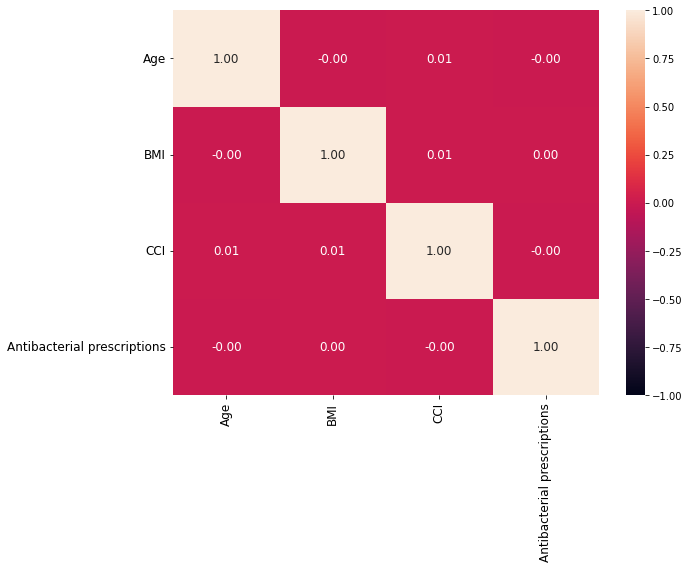

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_sinusitis[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/corr_sinusitis.jpg')
plt.show()

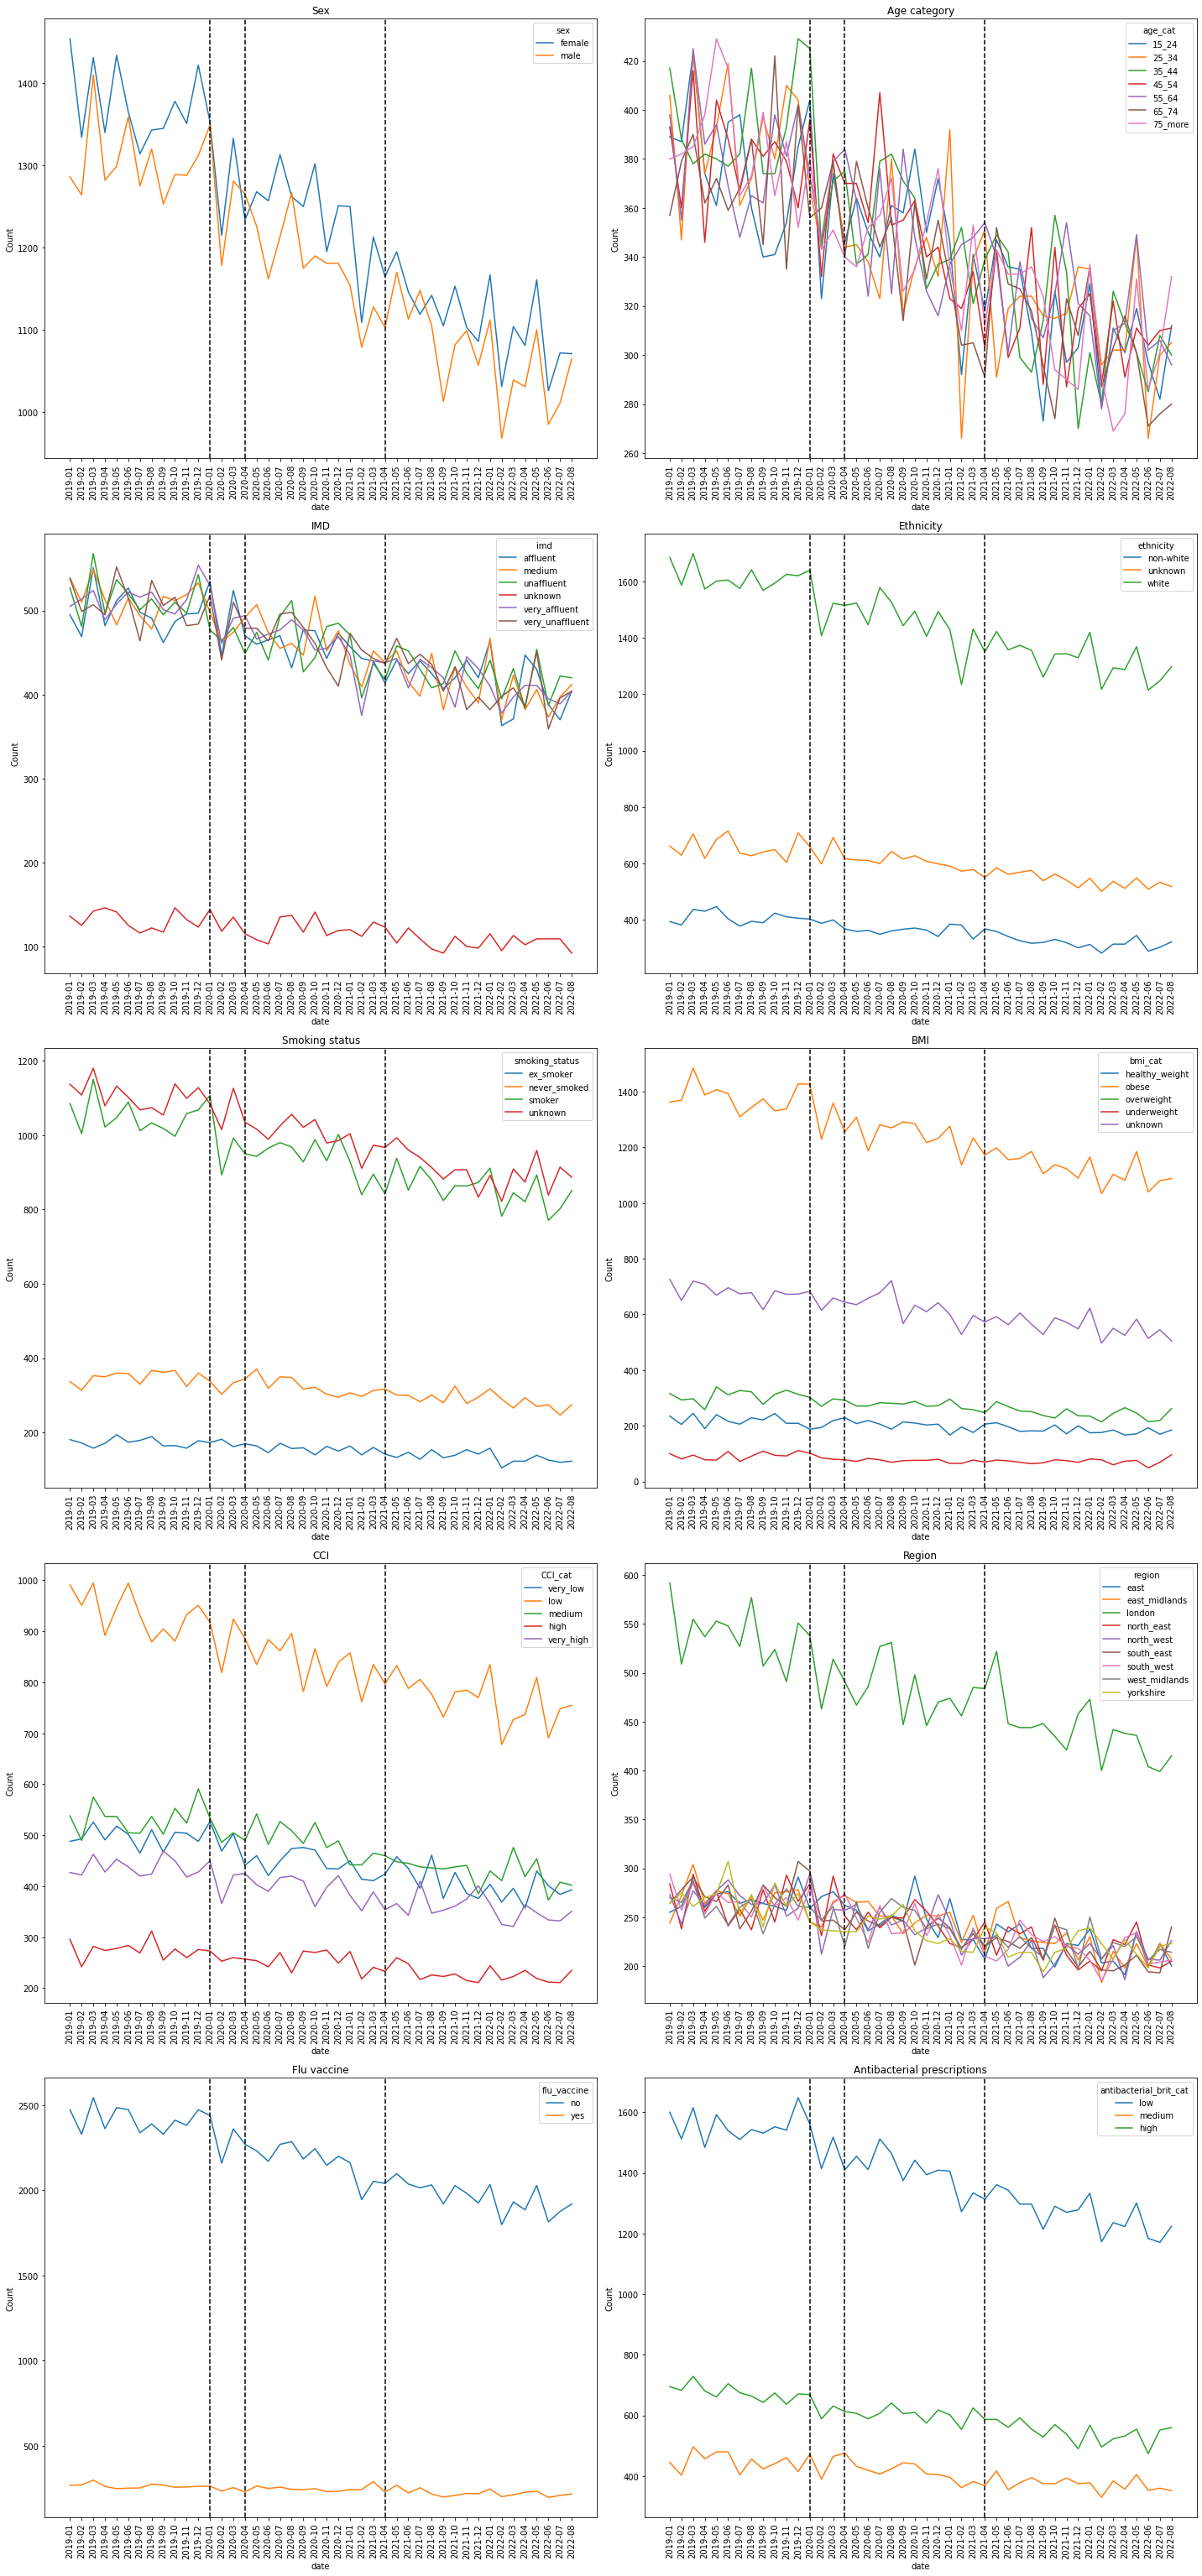

In [48]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_sinusitis, 'sex', 'Sex', axes[0,0])
create_lineplot(data_sinusitis, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_sinusitis, 'imd', 'IMD', axes[1,0])
create_lineplot(data_sinusitis, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_sinusitis, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_sinusitis, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_sinusitis, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_sinusitis, 'region', 'Region', axes[3,1])
create_lineplot(data_sinusitis, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_sinusitis, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of sinusitis patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_sinusitis/risk_factors_cat_sinusitis.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of sinusitis to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [49]:
data_sinusitis = data_sinusitis[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'sinusitis_ab_date', 'ab_type_cat', 'incdt_sinusitis_date', 'date', 'period',
                       'event_sinusitis_admitted', 'duration_sinusitis_admitted'
                        ]]

data_sinusitis.shape

(106110, 17)

In [50]:
#incident and prevalent infection 
data_sinusitis_incdt = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 0]
data_sinusitis_prevl = data_sinusitis[data_sinusitis['incdt_sinusitis_date'] == 1]
#switch variable sinusitis_ab_date into a binary variable
data_sinusitis_incdt[['sinusitis_ab_date']] = data_sinusitis_incdt[['sinusitis_ab_date']].where(data_sinusitis_incdt[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)
data_sinusitis_prevl[['sinusitis_ab_date']] = data_sinusitis_prevl[['sinusitis_ab_date']].where(data_sinusitis_prevl[['sinusitis_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_sinusitis_incdt_males = data_sinusitis_incdt[data_sinusitis_incdt['sex'] == 'male']
data_sinusitis_incdt_females = data_sinusitis_incdt[data_sinusitis_incdt['sex'] == 'female']
data_sinusitis_prevl_males = data_sinusitis_prevl[data_sinusitis_prevl['sex'] == 'male']
data_sinusitis_prevl_females = data_sinusitis_prevl[data_sinusitis_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_sinusitis_incdt_15_24 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '15_24']
data_sinusitis_incdt_25_34 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '25_34']
data_sinusitis_incdt_35_44 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '35_44']
data_sinusitis_incdt_45_54 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '45_54']
data_sinusitis_incdt_55_64 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '55_64']
data_sinusitis_incdt_65_74 = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '65_74']
data_sinusitis_incdt_75_more = data_sinusitis_incdt[data_sinusitis_incdt['age_cat'] == '75_more']
data_sinusitis_prevl_15_24 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '15_24']
data_sinusitis_prevl_25_34 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '25_34']
data_sinusitis_prevl_35_44 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '35_44']
data_sinusitis_prevl_45_54 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '45_54']
data_sinusitis_prevl_55_64 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '55_64']
data_sinusitis_prevl_65_74 = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '65_74']
data_sinusitis_prevl_75_more = data_sinusitis_prevl[data_sinusitis_prevl['age_cat'] == '75_more']

data_sinusitis_incdt_prepandemic = data_sinusitis_incdt[data_sinusitis_incdt['date'] <= '2019-12']
data_sinusitis_incdt_during_pandemic = data_sinusitis_incdt[(data_sinusitis_incdt['date'] >= '2020-03') & (data_sinusitis_incdt['date']<= '2021-03')]
data_sinusitis_incdt_post_2nd_lockdown = data_sinusitis_incdt[data_sinusitis_incdt['date'] <= '2021-04']
data_sinusitis_prevl_prepandemic = data_sinusitis_prevl[data_sinusitis_prevl['date'] <= '2019-12']
data_sinusitis_prevl_during_pandemic = data_sinusitis_prevl[(data_sinusitis_prevl['date'] >= '2020-03') & (data_sinusitis_prevl['date']<= '2021-03')]
data_sinusitis_prevl_post_2nd_lockdown = data_sinusitis_prevl[data_sinusitis_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_sinusitis_incdt_abtype_0 = data_sinusitis_incdt[data_sinusitis_incdt['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[0]]
# data_sinusitis_incdt_abtype_1 = data_sinusitis_incdt[data_sinusitis_incdt['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[1]]
# data_sinusitis_incdt_abtype_2 = data_sinusitis_incdt[data_sinusitis_incdt['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[2]]
# data_sinusitis_incdt_abtype_3 = data_sinusitis_incdt[data_sinusitis_incdt['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[3]]
# data_sinusitis_prevl_abtype_0 = data_sinusitis_prevl[data_sinusitis_prevl['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[0]]
# data_sinusitis_prevl_abtype_1 = data_sinusitis_prevl[data_sinusitis_prevl['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[1]]
# data_sinusitis_prevl_abtype_2 = data_sinusitis_prevl[data_sinusitis_prevl['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[2]]
# data_sinusitis_prevl_abtype_3 = data_sinusitis_prevl[data_sinusitis_prevl['ab_type_cat'] == data_sinusitis['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_sinusitis_incdt_abs = data_sinusitis_incdt[data_sinusitis_incdt['sinusitis_ab_date'] == 1]
# data_sinusitis_prevl_abs = data_sinusitis_prevl[data_sinusitis_prevl['sinusitis_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_sinusitis_no_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()] #gp_cons_sinusitis_ab
data_sinusitis_no_abs_incdt = data_sinusitis_no_abs_incdt[data_sinusitis_no_abs_incdt['incdt_sinusitis_date'] == 0]

# with antibiotics and incident hospital admission
data_sinusitis_abs_incdt = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_incdt = data_sinusitis_abs_incdt[data_sinusitis_abs_incdt['incdt_sinusitis_date'] == 0]

# no antibiotics and prevalent hospital admission
data_sinusitis_no_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].isnull()]
data_sinusitis_no_abs_prevl = data_sinusitis_no_abs_prevl[data_sinusitis_no_abs_prevl['incdt_sinusitis_date'] == 1]

# with antibiotics and prevalent hospital admission
data_sinusitis_abs_prevl = data_sinusitis[data_sinusitis['sinusitis_ab_date'].notnull()]
data_sinusitis_abs_prevl = data_sinusitis_abs_prevl[data_sinusitis_abs_prevl['incdt_sinusitis_date'] == 1]

print(f'shape of data_sinusitis_incdt: {data_sinusitis_incdt.shape}')
print(f'shape of data_sinusitis_prevl: {data_sinusitis_prevl.shape}')
print(f'shape of data_sinusitis_no_abs_incdt: {data_sinusitis_no_abs_incdt.shape}')
print(f'shape of data_sinusitis_abs_incdt: {data_sinusitis_abs_incdt.shape}')
print(f'shape of data_sinusitis_no_abs_prevl: {data_sinusitis_no_abs_prevl.shape}')
print(f'shape of data_sinusitis_abs_prevl: {data_sinusitis_abs_prevl.shape}')
print(f'\nvalue counts of data_sinusitis_no_abs_incdt: \n{data_sinusitis_no_abs_incdt.event_sinusitis_admitted.value_counts()}')
print(f'value counts of data_sinusitis_abs_incdt: \n{data_sinusitis_abs_incdt.event_sinusitis_admitted.value_counts()}')
print(f'value counts of data_sinusitis_no_abs_prevl: \n{data_sinusitis_no_abs_prevl.event_sinusitis_admitted.value_counts()}')
print(f'value counts of data_sinusitis_abs_prevl: \n{data_sinusitis_abs_prevl.event_sinusitis_admitted.value_counts()}')

shape of data_sinusitis_incdt: (95500, 17)
shape of data_sinusitis_prevl: (10610, 17)
shape of data_sinusitis_no_abs_incdt: (86044, 17)
shape of data_sinusitis_abs_incdt: (9456, 17)
shape of data_sinusitis_no_abs_prevl: (9587, 17)
shape of data_sinusitis_abs_prevl: (1023, 17)

value counts of data_sinusitis_no_abs_incdt: 
0.0    85415
1.0      629
Name: event_sinusitis_admitted, dtype: int64
value counts of data_sinusitis_abs_incdt: 
0.0    9382
1.0      74
Name: event_sinusitis_admitted, dtype: int64
value counts of data_sinusitis_no_abs_prevl: 
0.0    9506
1.0      81
Name: event_sinusitis_admitted, dtype: int64
value counts of data_sinusitis_abs_prevl: 
0.0    1020
1.0       3
Name: event_sinusitis_admitted, dtype: int64


In [51]:
#store data for plotting hosp admission counts and percentages
%store data_sinusitis
# save data
data_sinusitis.to_csv('../output/hospitalisation_prediction_sinusitis/data_sinusitis.csv')

Stored 'data_sinusitis' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 64533 total observations, 64069 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 64533
number of events observed = 464
   partial log-likelihood = -5117.18
         time fit was run = 2022-11-17 10:41:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.33       0.14             0.01             0.56                 1.01                 1.76
CCI_cat[T.medium]                0.12       1.13       0.16            -0.19             0.44                 0.83                 1.55
CCI_cat[T.high]                  0.24       1.27       0.19            -0.12             0.60                 0.89                 1.83
CCI_cat[T.very_high]             0.27       1.31       0.16            -0.05             0.59                 0.95                 1.81
age_cat[T.25_34]                -0.10       0.90       0.17            -0.43             0.22                 0.65                 1.25
age_cat[T.35_44]                -0.08       0.93       0.16            -0.40             0.24                 0.67                 1.28
age_cat[T.45_54]                -0.09       0.92       0.17            -0.41             0.24                 0.66                 1.27
age_cat[T.55_64]                -0.25       0.78       0.17            -0.58             0.09                 0.56                 1.10
age_cat[T.65_74]                -0.33       0.72       0.18            -0.68             0.02                 0.51                 1.02
age_cat[T.75_more]              -0.22       0.81       0.17            -0.55             0.12                 0.58                 1.13
antibacterial_brit              -0.02       0.98       0.03            -0.09             0.04                 0.91                 1.04
bmi_cat[T.obese]                -0.10       0.90       0.17            -0.43             0.23                 0.65                 1.26
bmi_cat[T.overweight]           -0.31       0.73       0.22            -0.74             0.12                 0.48                 1.13
bmi_cat[T.underweight]          -0.07       0.93       0.30            -0.66             0.52                 0.52                 1.68
bmi_cat[T.unknown]               0.07       1.08       0.18            -0.28             0.42                 0.76                 1.53
ethnicity[T.unknown]            -0.12       0.88       0.15            -0.43             0.18                 0.65                 1.20
ethnicity[T.white]               0.02       1.02       0.13            -0.24             0.28                 0.79                 1.33
flu_vaccine[T.yes]               0.16       1.18       0.14            -0.12             0.45                 0.89                 1.57
imd[T.medium]                   -0.02       0.98       0.15            -0.32             0.28                 0.73                 1.32
imd[T.unaffluent]                0.06       1.06       0.15            -0.24             0.35                 0.79                 1.42
imd[T.unknown]                  -0.13       0.88       0.25            -0.61             0.36                 0.54                 1.43
imd[T.very_affluent]             0.11       1.12       0.15            -0.18             0.40                 0.84                 1.49
imd[T.very_unaffluent]          -0.11       0.90       0.16            -0.41             0.20                 0.66                 1.22
region[T.east_midlands]          0.11       1.12       0.20            -0.27             0.50                 0.76                 1.64
region[T.london]                -0.15       0.86       0.1

12779


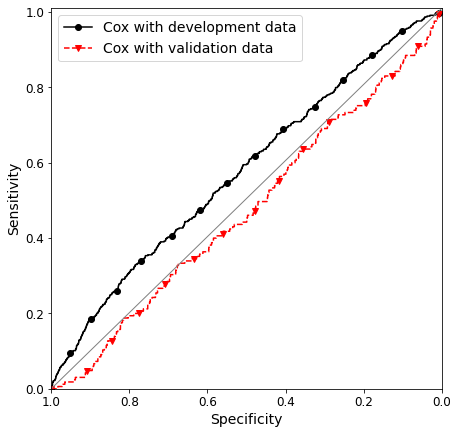

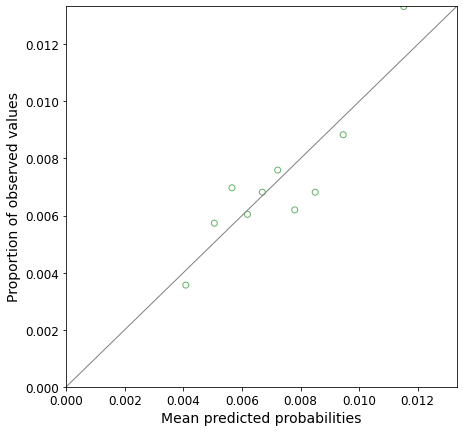

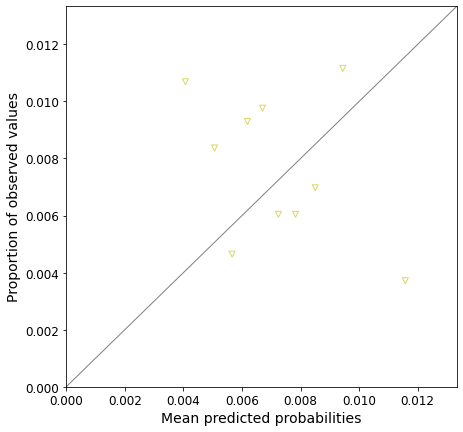

In [52]:
#data prep
data, data_sinusitis_no_abs_incdt_enc = cox_data_prep(data_sinusitis_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)

try:
    #build cox model 
    cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test = cox_model_build('sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_sinusitis_no_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_incdt.csv', data_sinusitis_no_abs_incdt_enc, data_sinusitis_no_abs_incdt, 'sum_betas_cph_sinusitis_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_sinusitis_no_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_sinusitis_no_abs_incdt, data_sinusitis_no_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_incdt_train.jpg', 'calibration_cph_sinusitis_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_no_abs_incdt, 'sinusitis', 'no_abs_incdt', data_sinusitis_no_abs_incdt_train, data_sinusitis_no_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 7092 total observations, 7036 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7092
number of events observed = 56
   partial log-likelihood = -475.53
         time fit was run = 2022-11-17 10:41:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.32       0.73       0.40            -1.10             0.47                 0.33                 1.59
CCI_cat[T.medium]                0.05       1.05       0.42            -0.77             0.87                 0.46                 2.39
CCI_cat[T.high]                  0.14       1.15       0.49            -0.81             1.10                 0.44                 3.00
CCI_cat[T.very_high]             0.20       1.22       0.43            -0.64             1.04                 0.52                 2.82
age_cat[T.25_34]                -0.78       0.46       0.69            -2.14             0.57                 0.12                 1.77
age_cat[T.35_44]                -0.09       0.91       0.54            -1.14             0.96                 0.32                 2.60
age_cat[T.45_54]                 0.49       1.64       0.48            -0.44             1.43                 0.64                 4.18
age_cat[T.55_64]                 0.08       1.08       0.52            -0.94             1.09                 0.39                 2.99
age_cat[T.65_74]                 0.07       1.07       0.52            -0.95             1.08                 0.39                 2.95
age_cat[T.75_more]               0.42       1.52       0.48            -0.53             1.37                 0.59                 3.93
antibacterial_brit              -0.08       0.93       0.10            -0.27             0.11                 0.77                 1.12
bmi_cat[T.obese]                 0.38       1.47       0.61            -0.81             1.58                 0.44                 4.87
bmi_cat[T.overweight]            0.03       1.03       0.77            -1.47             1.53                 0.23                 4.60
bmi_cat[T.underweight]           0.59       1.80       0.92            -1.21             2.39                 0.30                10.87
bmi_cat[T.unknown]               0.87       2.38       0.62            -0.35             2.08                 0.71                 8.01
ethnicity[T.unknown]             0.28       1.32       0.54            -0.78             1.34                 0.46                 3.83
ethnicity[T.white]               0.66       1.94       0.48            -0.27             1.60                 0.76                 4.93
flu_vaccine[T.yes]               0.37       1.44       0.41            -0.43             1.16                 0.65                 3.20
imd[T.medium]                    0.21       1.23       0.42            -0.62             1.04                 0.54                 2.82
imd[T.unaffluent]                0.11       1.12       0.43            -0.73             0.96                 0.48                 2.60
imd[T.unknown]                  -0.35       0.71       0.78            -1.87             1.18                 0.15                 3.25
imd[T.very_affluent]            -0.17       0.85       0.46            -1.07             0.74                 0.34                 2.09
imd[T.very_unaffluent]          -0.05       0.95       0.45            -0.93             0.83                 0.39                 2.29
region[T.east_midlands]         -0.21       0.81       0.76            -1.71             1.29                 0.18                 3.62
region[T.london]                 0.95       2.59       0.55    

12767


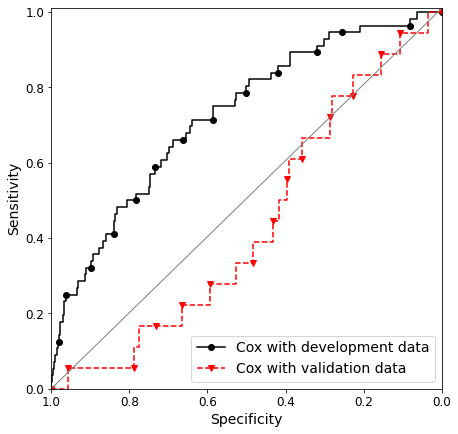

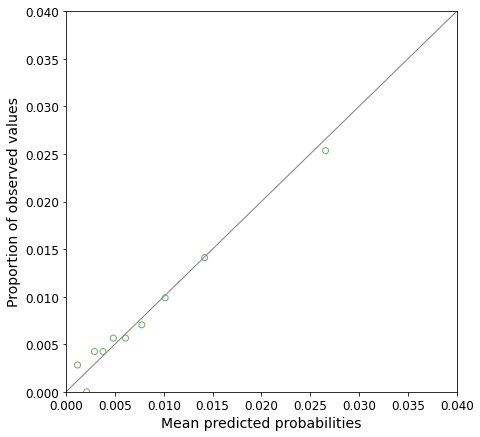

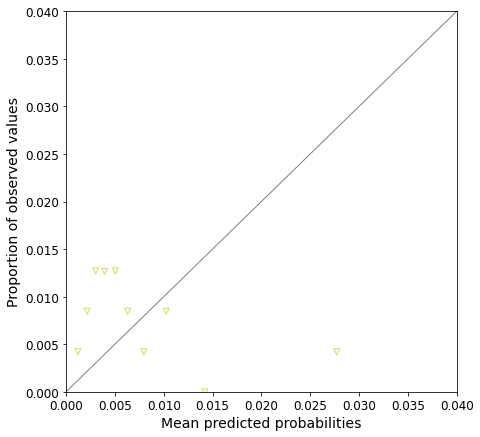

In [53]:
#data prep
data, data_sinusitis_abs_incdt_enc = cox_data_prep(data_sinusitis_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)

try:
    #build cox model 
    cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test = cox_model_build('sinusitis', 'abs_incdt', data_sinusitis_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_sinusitis_abs_incdt, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_incdt.csv', data_sinusitis_abs_incdt_enc, data_sinusitis_abs_incdt, 'sum_betas_cph_sinusitis_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_sinusitis_abs_incdt, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_sinusitis_abs_incdt, data_sinusitis_abs_incdt_train, 'event_sinusitis_admitted', data_sinusitis_abs_incdt_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_incdt_train.jpg', 'calibration_cph_sinusitis_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_abs_incdt, 'sinusitis', 'abs_incdt', data_sinusitis_abs_incdt_train, data_sinusitis_abs_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent sinusitis with no antibiotics

<lifelines.CoxPHFitter: fitted with 7190 total observations, 7130 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7190
number of events observed = 60
   partial log-likelihood = -508.69
         time fit was run = 2022-11-17 10:41:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.33       0.72       0.38            -1.07             0.42                 0.34                 1.51
CCI_cat[T.medium]               -0.05       0.95       0.40            -0.84             0.74                 0.43                 2.09
CCI_cat[T.high]                 -0.10       0.90       0.50            -1.09             0.88                 0.34                 2.41
CCI_cat[T.very_high]             0.09       1.09       0.41            -0.72             0.89                 0.49                 2.44
age_cat[T.25_34]                 0.82       2.28       0.50            -0.15             1.79                 0.86                 6.02
age_cat[T.35_44]                -0.15       0.86       0.61            -1.34             1.04                 0.26                 2.84
age_cat[T.45_54]                 0.72       2.05       0.50            -0.25             1.69                 0.78                 5.40
age_cat[T.55_64]                 0.38       1.46       0.53            -0.66             1.42                 0.52                 4.13
age_cat[T.65_74]                 0.36       1.43       0.54            -0.70             1.42                 0.50                 4.14
age_cat[T.75_more]               0.04       1.04       0.58            -1.09             1.17                 0.34                 3.24
antibacterial_brit               0.16       1.17       0.09            -0.01             0.33                 0.99                 1.40
bmi_cat[T.obese]                 0.08       1.08       0.48            -0.86             1.02                 0.42                 2.78
bmi_cat[T.overweight]           -0.13       0.88       0.61            -1.32             1.06                 0.27                 2.89
bmi_cat[T.underweight]           0.40       1.50       0.73            -1.04             1.84                 0.36                 6.31
bmi_cat[T.unknown]              -0.13       0.88       0.53            -1.17             0.90                 0.31                 2.46
ethnicity[T.unknown]            -0.47       0.63       0.41            -1.27             0.34                 0.28                 1.40
ethnicity[T.white]              -0.24       0.79       0.33            -0.89             0.42                 0.41                 1.52
flu_vaccine[T.yes]               0.18       1.20       0.40            -0.61             0.98                 0.54                 2.66
imd[T.medium]                    0.20       1.22       0.37            -0.53             0.93                 0.59                 2.55
imd[T.unaffluent]               -0.60       0.55       0.47            -1.52             0.32                 0.22                 1.38
imd[T.unknown]                   0.06       1.06       0.64            -1.21             1.32                 0.30                 3.73
imd[T.very_affluent]            -0.72       0.49       0.49            -1.69             0.25                 0.18                 1.28
imd[T.very_unaffluent]           0.10       1.11       0.38            -0.64             0.85                 0.53                 2.34
region[T.east_midlands]         -1.76       0.17       1.08            -3.88             0.36                 0.02                 1.44
region[T.london]                 0.47       1.59       0.47    

12780


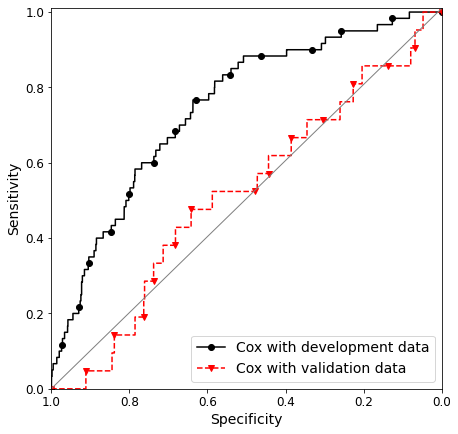

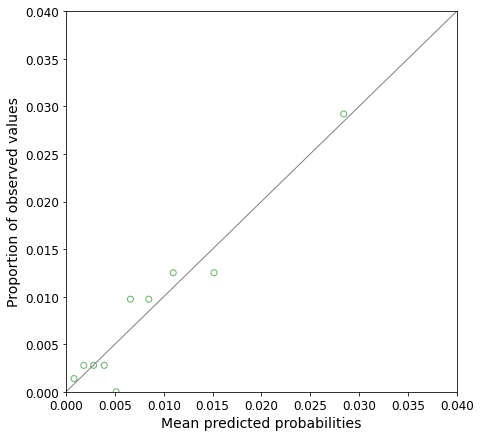

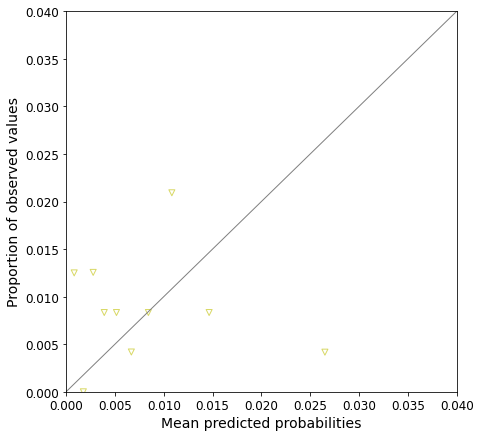

In [54]:
#data prep
data, data_sinusitis_no_abs_prevl_enc = cox_data_prep(data_sinusitis_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)

try:
    #build cox model 
    cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test = cox_model_build('sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_sinusitis_no_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_no_abs_prevl.csv', data_sinusitis_no_abs_prevl_enc, data_sinusitis_no_abs_prevl, 'sum_betas_cph_sinusitis_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_sinusitis_no_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_sinusitis_no_abs_prevl, data_sinusitis_no_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_no_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_no_abs_prevl_train.jpg', 'calibration_cph_sinusitis_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_no_abs_prevl, 'sinusitis', 'no_abs_prevl', data_sinusitis_no_abs_prevl_train, data_sinusitis_no_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent sinusitis with antibiotics

<lifelines.CoxPHFitter: fitted with 767 total observations, 765 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 767
number of events observed = 2
   partial log-likelihood = -0.00
         time fit was run = 2022-11-17 10:41:26 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   1.99       7.34    1665.77         -3262.86          3266.84                 0.00                  inf
CCI_cat[T.medium]               12.82   3.70e+05     976.73         -1901.53          1927.17                 0.00                  inf
CCI_cat[T.high]                  7.46    1739.79    1673.46         -3272.47          3287.39                 0.00                  inf
CCI_cat[T.very_high]            15.53   5.57e+06    1435.33         -2797.65          2828.72                 0.00                  inf
age_cat[T.25_34]                17.51   4.02e+07    2394.48         -4675.59          4710.61                 0.00                  inf
age_cat[T.35_44]                 0.47       1.60    2772.52         -5433.57          5434.51                 0.00                  inf
age_cat[T.45_54]                10.58   39444.08    2621.39         -5127.24          5148.41                 0.00                  inf
age_cat[T.55_64]                 4.65     104.53    2564.82         -5022.31          5031.61                 0.00                  inf
age_cat[T.65_74]                 8.09    3254.43    2883.48         -5643.44          5659.61                 0.00                  inf
age_cat[T.75_more]               2.65      14.15    2453.98         -4807.06          4812.36                 0.00                  inf
antibacterial_brit               2.07       7.93     330.57          -645.84           649.98                 0.00            1.93e+282
bmi_cat[T.obese]                -9.67       0.00    1025.62         -2019.84          2000.50                 0.00                  inf
bmi_cat[T.overweight]          -12.49       0.00    1430.58         -2816.38          2791.39                 0.00                  inf
bmi_cat[T.underweight]           3.50      33.28    3339.75         -6542.28          6549.29                 0.00                  inf
bmi_cat[T.unknown]             -11.40       0.00    2455.94         -4824.95          4802.15                 0.00                  inf
ethnicity[T.unknown]             2.78      16.14    3410.73         -6682.13          6687.69                 0.00                  inf
ethnicity[T.white]               8.62    5518.98    2990.56         -5852.78          5870.01                 0.00                  inf
flu_vaccine[T.yes]              -3.81       0.02    1763.19         -3459.61          3451.98                 0.00                  inf
imd[T.medium]                   -3.10       0.04    2147.92         -4212.95          4206.74                 0.00                  inf
imd[T.unaffluent]               -7.59       0.00    2501.98         -4911.37          4896.20                 0.00                  inf
imd[T.unknown]                  -0.66       0.52    2584.52         -5066.22          5064.91                 0.00                  inf
imd[T.very_affluent]             5.49     241.10    1393.87         -2726.45          2737.42                 0.00                  inf
imd[T.very_unaffluent]           6.43     621.41    1364.42         -2667.77          2680.64                 0.00                  inf
region[T.east_midlands]         -7.44       0.00    1981.13         -3890.39          3875.50                 0.00                  inf
region[T.london]               -11.53       0.00    1586.49         -

13125


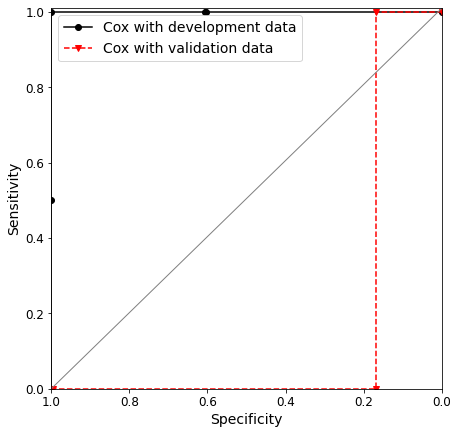

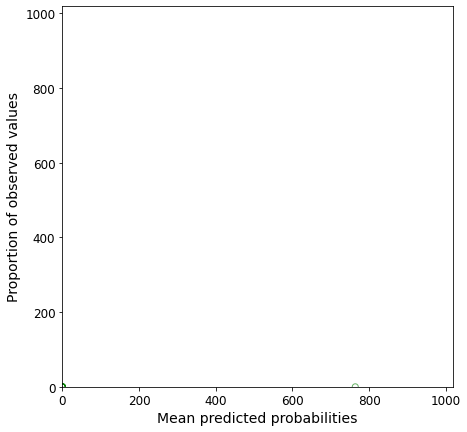

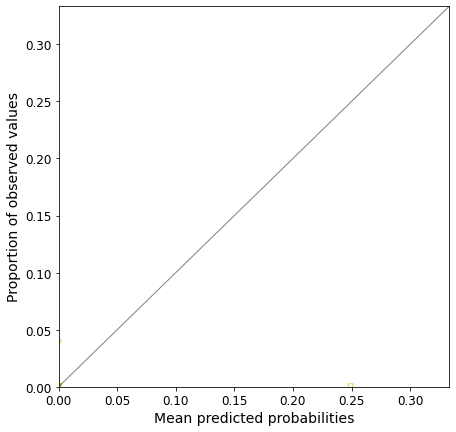

In [55]:
#data prep
data, data_sinusitis_abs_prevl_enc = cox_data_prep(data_sinusitis_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary table
make_summary_table('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)

try:
    #build cox model 
    cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test = cox_model_build('sinusitis', 'abs_prevl', data_sinusitis_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_sinusitis_abs_prevl, '../output/hospitalisation_prediction_sinusitis/', 'betas_cph_sinusitis_abs_prevl.csv', data_sinusitis_abs_prevl_enc, data_sinusitis_abs_prevl, 'sum_betas_cph_sinusitis_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_sinusitis_abs_prevl, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis', 'roc_cph_sinusitis_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_sinusitis_abs_prevl, data_sinusitis_abs_prevl_train, 'event_sinusitis_admitted', data_sinusitis_abs_prevl_test, '../output/hospitalisation_prediction_sinusitis/', 'calibration_cph_sinusitis_abs_prevl_train.jpg', 'calibration_cph_sinusitis_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_abs_prevl, 'sinusitis', 'abs_prevl', data_sinusitis_abs_prevl_train, data_sinusitis_abs_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-5- incident sinusitis

In [56]:
#data prep
data, data_sinusitis_incdt_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'incdt', data_sinusitis_incdt_enc)
make_summary_table_hosped('sinusitis', 'incdt', data_sinusitis_incdt)

try:
    cph_sinusitis_incdt, data_sinusitis_incdt_train, data_sinusitis_incdt_test = cox_model_abs_build('sinusitis', 'incdt', data_sinusitis_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt, 'sinusitis', 'incdt', data_sinusitis_incdt_train, data_sinusitis_incdt_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71625 total observations, 71082 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 71625
number of events observed = 543
   partial log-likelihood = -6055.73
         time fit was run = 2022-11-17 10:41:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.13            -0.13             0.37                 0.88                 1.44
CCI_cat[T.medium]                0.06       1.06       0.14            -0.22             0.34                 0.80                 1.41
CCI_cat[T.high]                  0.11       1.12       0.17            -0.22             0.44                 0.80                 1.55
CCI_cat[T.very_high]             0.14       1.15       0.15            -0.15             0.43                 0.86                 1.53
age_cat[T.25_34]                 0.00       1.00       0.16            -0.30             0.31                 0.74                 1.37
age_cat[T.35_44]                -0.02       0.98       0.16            -0.33             0.29                 0.72                 1.33
age_cat[T.45_54]                 0.04       1.04       0.16            -0.27             0.34                 0.76                 1.41
age_cat[T.55_64]                -0.14       0.87       0.16            -0.46             0.18                 0.63                 1.20
age_cat[T.65_74]                -0.09       0.92       0.16            -0.41             0.23                 0.67                 1.26
age_cat[T.75_more]              -0.07       0.93       0.16            -0.39             0.24                 0.68                 1.27
antibacterial_brit              -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
bmi_cat[T.obese]                -0.10       0.91       0.16            -0.40             0.21                 0.67                 1.23
bmi_cat[T.overweight]           -0.23       0.80       0.20            -0.62             0.16                 0.54                 1.17
bmi_cat[T.underweight]          -0.25       0.78       0.30            -0.83             0.33                 0.44                 1.39
bmi_cat[T.unknown]               0.01       1.01       0.16            -0.32             0.33                 0.73                 1.39
ethnicity[T.unknown]            -0.13       0.88       0.14            -0.41             0.15                 0.66                 1.16
ethnicity[T.white]               0.00       1.01       0.12            -0.24             0.25                 0.79                 1.28
flu_vaccine[T.yes]              -0.04       0.96       0.15            -0.33             0.24                 0.72                 1.28
imd[T.medium]                    0.14       1.15       0.14            -0.13             0.41                 0.88                 1.50
imd[T.unaffluent]               -0.01       0.99       0.14            -0.29             0.27                 0.75                 1.31
imd[T.unknown]                  -0.10       0.90       0.23            -0.56             0.35                 0.57                 1.42
imd[T.very_affluent]             0.16       1.18       0.14            -0.11             0.43                 0.90                 1.54
imd[T.very_unaffluent]          -0.05       0.95       0.14            -0.33             0.24                 0.72                 1.27
region[T.east_midlands]         -0.03       0.97       0.19            -0.41             0.35                 0.66                 1.41
region[T.london]                 0.03       1.03       0.1

13053


### 5-6- hospital admission related to prevalent sinusitis

In [57]:
#data prep
data, data_sinusitis_prevl_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

#make summary tables from preped data
make_summary_table('sinusitis', 'prevl', data_sinusitis_prevl_enc)
make_summary_table_hosped('sinusitis', 'prevl', data_sinusitis_prevl)

try:
    cph_sinusitis_prevl, data_sinusitis_prevl_train, data_sinusitis_prevl_test = cox_model_abs_build('sinusitis', 'prevl', data_sinusitis_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl, 'sinusitis', 'prevl', data_sinusitis_prevl_train, data_sinusitis_prevl_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7957 total observations, 7895 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7957
number of events observed = 62
   partial log-likelihood = -529.75
         time fit was run = 2022-11-17 10:41:31 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.39            -1.02             0.52                 0.36                 1.68
CCI_cat[T.medium]                0.11       1.11       0.41            -0.70             0.91                 0.50                 2.49
CCI_cat[T.high]                  0.01       1.01       0.51            -0.99             1.01                 0.37                 2.74
CCI_cat[T.very_high]             0.52       1.68       0.39            -0.26             1.29                 0.77                 3.63
age_cat[T.25_34]                 0.44       1.56       0.47            -0.47             1.36                 0.62                 3.89
age_cat[T.35_44]                -0.60       0.55       0.61            -1.80             0.61                 0.17                 1.84
age_cat[T.45_54]                 0.46       1.59       0.45            -0.42             1.34                 0.66                 3.84
age_cat[T.55_64]                -0.24       0.79       0.54            -1.30             0.82                 0.27                 2.27
age_cat[T.65_74]                 0.14       1.15       0.50            -0.85             1.12                 0.43                 3.07
age_cat[T.75_more]               0.49       1.63       0.46            -0.41             1.39                 0.66                 4.00
antibacterial_brit               0.21       1.23       0.09             0.04             0.38                 1.04                 1.46
bmi_cat[T.obese]                -0.38       0.68       0.42            -1.21             0.45                 0.30                 1.57
bmi_cat[T.overweight]           -0.68       0.50       0.59            -1.84             0.47                 0.16                 1.59
bmi_cat[T.underweight]          -0.10       0.91       0.69            -1.46             1.26                 0.23                 3.54
bmi_cat[T.unknown]              -0.14       0.87       0.45            -1.01             0.74                 0.36                 2.09
ethnicity[T.unknown]            -0.13       0.88       0.42            -0.94             0.69                 0.39                 1.99
ethnicity[T.white]              -0.04       0.96       0.36            -0.74             0.66                 0.48                 1.94
flu_vaccine[T.yes]               0.15       1.17       0.40            -0.64             0.94                 0.53                 2.57
imd[T.medium]                    0.18       1.20       0.36            -0.53             0.89                 0.59                 2.43
imd[T.unaffluent]               -0.34       0.71       0.42            -1.16             0.47                 0.31                 1.60
imd[T.unknown]                  -1.16       0.31       1.04            -3.19             0.88                 0.04                 2.40
imd[T.very_affluent]            -1.25       0.29       0.57            -2.37            -0.14                 0.09                 0.87
imd[T.very_unaffluent]           0.15       1.16       0.37            -0.57             0.87                 0.56                 2.38
region[T.east_midlands]         -1.79       0.17       1.08            -3.91             0.33                 0.02                 1.39
region[T.london]                 0.47       1.60       0.47    

13056


### 5-7- hospital admission related to incident sinusitis with prescribed antibiotics categories

In [58]:
#data prep
data, data_sinusitis_incdt_abs_enc = cox_data_prep(data_sinusitis_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_abs, data_sinusitis_incdt_abs_train, data_sinusitis_incdt_abs_test = cox_model_ab_type_build('sinusitis', 'incdt_ab_type', data_sinusitis_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_abs, 'sinusitis', 'incdt_abs', data_sinusitis_incdt_abs_train, data_sinusitis_incdt_abs_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71625 total observations, 71082 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 71625
number of events observed = 543
   partial log-likelihood = -6054.60
         time fit was run = 2022-11-17 10:41:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.13            -0.13             0.37                 0.88                 1.44
CCI_cat[T.medium]                0.06       1.06       0.14            -0.22             0.34                 0.80                 1.41
CCI_cat[T.high]                  0.11       1.12       0.17            -0.22             0.44                 0.80                 1.55
CCI_cat[T.very_high]             0.14       1.15       0.15            -0.15             0.43                 0.86                 1.53
ab_type_cat[T.Doxycycline]     -12.74       0.00     567.73         -1125.47          1100.00                 0.00                  inf
ab_type_cat[T.no]                0.07       1.07       0.58            -1.07             1.20                 0.34                 3.32
ab_type_cat[T.other]             0.07       1.08       0.59            -1.09             1.24                 0.34                 3.45
age_cat[T.25_34]                 0.00       1.00       0.16            -0.30             0.31                 0.74                 1.37
age_cat[T.35_44]                -0.02       0.98       0.16            -0.33             0.29                 0.72                 1.33
age_cat[T.45_54]                 0.04       1.04       0.16            -0.27             0.34                 0.76                 1.41
age_cat[T.55_64]                -0.14       0.87       0.16            -0.46             0.18                 0.63                 1.20
age_cat[T.65_74]                -0.09       0.92       0.16            -0.41             0.23                 0.67                 1.26
age_cat[T.75_more]              -0.07       0.93       0.16            -0.39             0.24                 0.68                 1.27
antibacterial_brit              -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
bmi_cat[T.obese]                -0.10       0.91       0.16            -0.40             0.21                 0.67                 1.23
bmi_cat[T.overweight]           -0.23       0.80       0.20            -0.62             0.16                 0.54                 1.17
bmi_cat[T.underweight]          -0.25       0.78       0.30            -0.83             0.33                 0.44                 1.39
bmi_cat[T.unknown]               0.01       1.01       0.16            -0.32             0.33                 0.73                 1.39
ethnicity[T.unknown]            -0.13       0.88       0.14            -0.41             0.15                 0.66                 1.16
ethnicity[T.white]               0.01       1.01       0.12            -0.23             0.25                 0.79                 1.28
flu_vaccine[T.yes]              -0.04       0.96       0.15            -0.33             0.24                 0.72                 1.28
imd[T.medium]                    0.14       1.15       0.14            -0.13             0.41                 0.88                 1.50
imd[T.unaffluent]               -0.01       0.99       0.14            -0.29             0.27                 0.75                 1.31
imd[T.unknown]                  -0.11       0.90       0.23            -0.56             0.35                 0.57                 1.42
imd[T.very_affluent]             0.16       1.18       0.1

13619


### 5-8- hospital admission related to prevalent sinusitis with prescribed antibiotics categories

In [59]:
#data prep
data, data_sinusitis_prevl_abs_enc = cox_data_prep(data_sinusitis_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_abs, data_sinusitis_prevl_abs_train, data_sinusitis_prevl_abs_test = cox_model_ab_type_build('sinusitis', 'prevl_ab_type', data_sinusitis_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_abs, 'sinusitis', 'prevl_abs', data_sinusitis_prevl_abs_train, data_sinusitis_prevl_abs_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 7957 total observations, 7895 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 7957
number of events observed = 62
   partial log-likelihood = -529.50
         time fit was run = 2022-11-17 10:41:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.25       0.78       0.39            -1.03             0.52                 0.36                 1.68
CCI_cat[T.medium]                0.11       1.11       0.41            -0.70             0.91                 0.50                 2.49
CCI_cat[T.high]                  0.01       1.01       0.51            -0.99             1.00                 0.37                 2.73
CCI_cat[T.very_high]             0.51       1.67       0.39            -0.26             1.28                 0.77                 3.61
ab_type_cat[T.Doxycycline]       0.15       1.16    5182.06        -10156.51         10156.80                 0.00                  inf
ab_type_cat[T.no]               14.85   2.82e+06    2713.41         -5303.33          5333.03                 0.00                  inf
ab_type_cat[T.other]            14.17   1.43e+06    2713.41         -5304.01          5332.35                 0.00                  inf
age_cat[T.25_34]                 0.45       1.56       0.47            -0.47             1.36                 0.63                 3.90
age_cat[T.35_44]                -0.60       0.55       0.61            -1.80             0.61                 0.16                 1.83
age_cat[T.45_54]                 0.46       1.58       0.45            -0.42             1.34                 0.65                 3.83
age_cat[T.55_64]                -0.24       0.79       0.54            -1.31             0.82                 0.27                 2.27
age_cat[T.65_74]                 0.14       1.15       0.50            -0.84             1.13                 0.43                 3.08
age_cat[T.75_more]               0.49       1.63       0.46            -0.41             1.39                 0.66                 4.00
antibacterial_brit               0.21       1.23       0.09             0.04             0.38                 1.04                 1.46
bmi_cat[T.obese]                -0.38       0.68       0.42            -1.21             0.45                 0.30                 1.57
bmi_cat[T.overweight]           -0.68       0.51       0.59            -1.83             0.47                 0.16                 1.60
bmi_cat[T.underweight]          -0.10       0.91       0.69            -1.46             1.27                 0.23                 3.54
bmi_cat[T.unknown]              -0.14       0.87       0.45            -1.01             0.74                 0.36                 2.10
ethnicity[T.unknown]            -0.12       0.89       0.42            -0.94             0.69                 0.39                 2.00
ethnicity[T.white]              -0.04       0.97       0.36            -0.74             0.67                 0.48                 1.94
flu_vaccine[T.yes]               0.15       1.16       0.40            -0.64             0.94                 0.53                 2.56
imd[T.medium]                    0.18       1.20       0.36            -0.53             0.89                 0.59                 2.44
imd[T.unaffluent]               -0.34       0.71       0.42            -1.15             0.47                 0.32                 1.61
imd[T.unknown]                  -1.15       0.32       1.04            -3.18             0.88                 0.04                 2.41
imd[T.very_affluent]            -1.25       0.29       0.57    

13648


### 5-9- stratified by sex
#### 5-9-1- incident males

In [60]:
#data prep
data, data_sinusitis_incdt_males_enc = cox_data_prep(data_sinusitis_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_males, data_sinusitis_incdt_males_train, data_sinusitis_incdt_males_test = cox_model_strat_sex_build('sinusitis', 'incdt_males', data_sinusitis_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_males, 'sinusitis', 'incdt_males', data_sinusitis_incdt_males_train, data_sinusitis_incdt_males_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 34986 total observations, 34723 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 34986
number of events observed = 263
   partial log-likelihood = -2730.50
         time fit was run = 2022-11-17 10:41:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.24       1.27       0.19            -0.14             0.62                 0.87                 1.85
CCI_cat[T.medium]                0.23       1.26       0.21            -0.19             0.65                 0.83                 1.92
CCI_cat[T.high]                  0.19       1.21       0.25            -0.31             0.69                 0.73                 1.99
CCI_cat[T.very_high]             0.48       1.62       0.21             0.07             0.90                 1.07                 2.45
age_cat[T.25_34]                 0.53       1.70       0.24             0.06             1.00                 1.06                 2.71
age_cat[T.35_44]                 0.50       1.66       0.24             0.03             0.97                 1.04                 2.65
age_cat[T.45_54]                 0.29       1.33       0.25            -0.21             0.78                 0.81                 2.18
age_cat[T.55_64]                 0.28       1.32       0.25            -0.21             0.78                 0.81                 2.17
age_cat[T.65_74]                 0.21       1.24       0.26            -0.29             0.72                 0.75                 2.04
age_cat[T.75_more]               0.30       1.34       0.25            -0.20             0.79                 0.82                 2.20
antibacterial_brit              -0.05       0.95       0.04            -0.14             0.04                 0.87                 1.04
bmi_cat[T.obese]                 0.13       1.14       0.24            -0.35             0.61                 0.70                 1.84
bmi_cat[T.overweight]           -0.03       0.97       0.30            -0.62             0.56                 0.54                 1.75
bmi_cat[T.underweight]           0.35       1.41       0.38            -0.40             1.09                 0.67                 2.97
bmi_cat[T.unknown]               0.11       1.12       0.26            -0.40             0.62                 0.67                 1.87
ethnicity[T.unknown]             0.01       1.01       0.21            -0.41             0.42                 0.67                 1.52
ethnicity[T.white]               0.14       1.15       0.18            -0.22             0.50                 0.80                 1.66
flu_vaccine[T.yes]               0.28       1.32       0.18            -0.08             0.64                 0.92                 1.89
imd[T.medium]                   -0.13       0.88       0.20            -0.53             0.27                 0.59                 1.30
imd[T.unaffluent]               -0.10       0.91       0.20            -0.50             0.31                 0.61                 1.36
imd[T.unknown]                  -0.63       0.53       0.40            -1.42             0.16                 0.24                 1.18
imd[T.very_affluent]            -0.07       0.93       0.20            -0.47             0.32                 0.63                 1.38
imd[T.very_unaffluent]           0.26       1.29       0.19            -0.11             0.62                 0.90                 1.87
region[T.east_midlands]          0.03       1.03       0.28            -0.51             0.57                 0.60                 1.76
region[T.london]                 0.06       1.07       0.2

12767


#### 5-9-2- incident females

In [61]:
#data prep
data, data_sinusitis_incdt_females_enc = cox_data_prep(data_sinusitis_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_females, data_sinusitis_incdt_females_train, data_sinusitis_incdt_females_test = cox_model_strat_sex_build('sinusitis', 'incdt_females', data_sinusitis_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_females, 'sinusitis', 'incdt_females', data_sinusitis_incdt_females_train, data_sinusitis_incdt_females_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36638 total observations, 36366 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 36638
number of events observed = 272
   partial log-likelihood = -2832.13
         time fit was run = 2022-11-17 10:41:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.07       1.07       0.18            -0.29             0.42                 0.75                 1.52
CCI_cat[T.medium]                0.11       1.12       0.20            -0.28             0.50                 0.76                 1.66
CCI_cat[T.high]                  0.12       1.12       0.24            -0.35             0.58                 0.71                 1.79
CCI_cat[T.very_high]             0.18       1.20       0.21            -0.22             0.59                 0.80                 1.80
age_cat[T.25_34]                -0.32       0.72       0.22            -0.76             0.11                 0.47                 1.12
age_cat[T.35_44]                -0.52       0.59       0.23            -0.98            -0.06                 0.38                 0.94
age_cat[T.45_54]                -0.05       0.95       0.21            -0.46             0.35                 0.63                 1.42
age_cat[T.55_64]                -0.42       0.65       0.23            -0.87             0.02                 0.42                 1.02
age_cat[T.65_74]                -0.11       0.89       0.21            -0.53             0.30                 0.59                 1.35
age_cat[T.75_more]              -0.22       0.80       0.22            -0.64             0.20                 0.53                 1.23
antibacterial_brit               0.03       1.03       0.04            -0.05             0.11                 0.95                 1.12
bmi_cat[T.obese]                -0.19       0.83       0.21            -0.61             0.23                 0.54                 1.26
bmi_cat[T.overweight]           -0.55       0.57       0.30            -1.14             0.03                 0.32                 1.03
bmi_cat[T.underweight]          -0.21       0.81       0.40            -1.00             0.58                 0.37                 1.79
bmi_cat[T.unknown]               0.08       1.08       0.22            -0.36             0.52                 0.70                 1.68
ethnicity[T.unknown]            -0.30       0.74       0.20            -0.70             0.09                 0.50                 1.10
ethnicity[T.white]              -0.05       0.95       0.17            -0.38             0.28                 0.68                 1.32
flu_vaccine[T.yes]              -0.26       0.77       0.23            -0.71             0.18                 0.49                 1.20
imd[T.medium]                    0.16       1.18       0.19            -0.20             0.53                 0.82                 1.70
imd[T.unaffluent]               -0.19       0.83       0.20            -0.58             0.21                 0.56                 1.23
imd[T.unknown]                  -0.24       0.79       0.33            -0.89             0.41                 0.41                 1.51
imd[T.very_affluent]             0.12       1.13       0.19            -0.24             0.49                 0.78                 1.64
imd[T.very_unaffluent]          -0.32       0.73       0.21            -0.73             0.10                 0.48                 1.10
region[T.east_midlands]         -0.01       0.99       0.29            -0.59             0.56                 0.56                 1.75
region[T.london]                 0.12       1.13       0.2

12783


#### 5-9-3- prevalent males

In [62]:
#data prep
data, data_sinusitis_prevl_males_enc = cox_data_prep(data_sinusitis_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_males, data_sinusitis_prevl_males_train, data_sinusitis_prevl_males_test = cox_model_strat_sex_build('sinusitis', 'prevl_males', data_sinusitis_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_males, 'sinusitis', 'prevl_males', data_sinusitis_prevl_males_train, data_sinusitis_prevl_males_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3913 total observations, 3879 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 3913
number of events observed = 34
   partial log-likelihood = -264.92
         time fit was run = 2022-11-17 10:41:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.47            -0.99             0.86                 0.37                 2.37
CCI_cat[T.medium]                0.01       1.01       0.54            -1.05             1.06                 0.35                 2.90
CCI_cat[T.high]                 -0.30       0.74       0.70            -1.66             1.07                 0.19                 2.91
CCI_cat[T.very_high]            -0.47       0.63       0.63            -1.70             0.77                 0.18                 2.15
age_cat[T.25_34]                 0.70       2.01       0.65            -0.58             1.98                 0.56                 7.25
age_cat[T.35_44]                -0.46       0.63       0.87            -2.17             1.24                 0.11                 3.46
age_cat[T.45_54]                 0.24       1.27       0.68            -1.08             1.56                 0.34                 4.77
age_cat[T.55_64]                 0.33       1.39       0.68            -0.99             1.65                 0.37                 5.23
age_cat[T.65_74]                 0.67       1.95       0.65            -0.61             1.94                 0.54                 6.99
age_cat[T.75_more]               0.59       1.81       0.65            -0.69             1.87                 0.50                 6.51
antibacterial_brit               0.25       1.29       0.11             0.03             0.48                 1.03                 1.61
bmi_cat[T.obese]                -0.48       0.62       0.56            -1.58             0.62                 0.21                 1.87
bmi_cat[T.overweight]           -0.44       0.64       0.71            -1.83             0.95                 0.16                 2.60
bmi_cat[T.underweight]          -0.62       0.54       1.13            -2.83             1.59                 0.06                 4.91
bmi_cat[T.unknown]              -0.42       0.65       0.62            -1.64             0.79                 0.19                 2.20
ethnicity[T.unknown]            -0.44       0.64       0.52            -1.47             0.58                 0.23                 1.79
ethnicity[T.white]              -0.54       0.58       0.45            -1.42             0.34                 0.24                 1.41
flu_vaccine[T.yes]               0.40       1.49       0.49            -0.56             1.36                 0.57                 3.88
imd[T.medium]                   -0.49       0.62       0.55            -1.55             0.58                 0.21                 1.79
imd[T.unaffluent]               -0.05       0.95       0.50            -1.04             0.94                 0.35                 2.56
imd[T.unknown]                  -0.79       0.45       1.07            -2.88             1.30                 0.06                 3.67
imd[T.very_affluent]            -1.48       0.23       0.79            -3.03             0.08                 0.05                 1.08
imd[T.very_unaffluent]           0.09       1.09       0.49            -0.87             1.05                 0.42                 2.86
region[T.east_midlands]         -0.17       0.84       1.42            -2.95             2.61                 0.05                13.56
region[T.london]                 1.15       3.15       1.07    

12789


#### 5-9-4- prevalent females

In [63]:
try:
    #data prep
    data, data_sinusitis_prevl_females_enc = cox_data_prep(data_sinusitis_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

    #cox model
    cph_sinusitis_prevl_females, data_sinusitis_prevl_females_train, data_sinusitis_prevl_females_test = cox_model_strat_sex_build('sinusitis', 'prevl_females', data_sinusitis_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_females, 'sinusitis', 'prevl_females', data_sinusitis_prevl_females_train, data_sinusitis_prevl_females_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4044 total observations, 4013 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 4044
number of events observed = 31
   partial log-likelihood = -235.71
         time fit was run = 2022-11-17 10:41:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.56       0.57       0.58            -1.70             0.58                 0.18                 1.78
CCI_cat[T.medium]                0.21       1.23       0.55            -0.86             1.28                 0.42                 3.58
CCI_cat[T.high]                 -1.14       0.32       1.09            -3.27             0.98                 0.04                 2.68
CCI_cat[T.very_high]             0.61       1.84       0.52            -0.42             1.64                 0.66                 5.15
age_cat[T.25_34]                 1.16       3.18       0.81            -0.43             2.74                 0.65                15.49
age_cat[T.35_44]                -0.69       0.50       1.23            -3.10             1.72                 0.05                 5.57
age_cat[T.45_54]                 1.04       2.83       0.82            -0.57             2.65                 0.57                14.21
age_cat[T.55_64]                 0.93       2.53       0.82            -0.68             2.54                 0.51                12.63
age_cat[T.65_74]                 0.76       2.14       0.84            -0.89             2.41                 0.41                11.11
age_cat[T.75_more]               0.65       1.92       0.87            -1.05             2.35                 0.35                10.53
antibacterial_brit               0.09       1.10       0.13            -0.15             0.34                 0.86                 1.41
bmi_cat[T.obese]                -0.26       0.77       0.64            -1.51             1.00                 0.22                 2.71
bmi_cat[T.overweight]           -0.40       0.67       0.83            -2.02             1.22                 0.13                 3.39
bmi_cat[T.underweight]          -0.22       0.80       1.17            -2.51             2.07                 0.08                 7.93
bmi_cat[T.unknown]              -0.03       0.97       0.68            -1.35             1.29                 0.26                 3.65
ethnicity[T.unknown]            -0.44       0.64       0.58            -1.58             0.71                 0.21                 2.03
ethnicity[T.white]              -0.13       0.87       0.47            -1.06             0.80                 0.35                 2.22
flu_vaccine[T.yes]              -1.21       0.30       1.02            -3.21             0.80                 0.04                 2.22
imd[T.medium]                    1.16       3.18       0.66            -0.14             2.45                 0.87                11.62
imd[T.unaffluent]               -0.09       0.91       0.82            -1.70             1.52                 0.18                 4.58
imd[T.unknown]                   1.44       4.21       0.83            -0.18             3.06                 0.84                21.24
imd[T.very_affluent]             0.79       2.21       0.71            -0.60             2.18                 0.55                 8.86
imd[T.very_unaffluent]           0.60       1.82       0.71            -0.80             1.99                 0.45                 7.34
region[T.east_midlands]         -0.45       0.64       0.73            -1.88             0.99                 0.15                 2.70
region[T.london]                -0.27       0.76       0.58    

12795


### 5-10- stratified by age category
#### 5-10-1- incident

In [64]:
#data prep
data, data_sinusitis_incdt_15_24_enc = cox_data_prep(data_sinusitis_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_15_24, data_sinusitis_incdt_15_24_train, data_sinusitis_incdt_15_24_test = cox_model_strat_age_build('sinusitis', 'incdt_15_24', data_sinusitis_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_15_24, 'sinusitis', 'incdt_15_24', data_sinusitis_incdt_15_24_train, data_sinusitis_incdt_15_24_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10172 total observations, 10093 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 10172
number of events observed = 79
   partial log-likelihood = -709.93
         time fit was run = 2022-11-17 10:41:43 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.36       1.43       0.36            -0.34             1.06                 0.71                 2.88
CCI_cat[T.medium]                0.48       1.61       0.38            -0.27             1.23                 0.76                 3.42
CCI_cat[T.high]                  0.44       1.56       0.45            -0.44             1.33                 0.64                 3.77
CCI_cat[T.very_high]             0.35       1.42       0.41            -0.45             1.16                 0.64                 3.18
antibacterial_brit               0.05       1.05       0.08            -0.10             0.20                 0.90                 1.22
bmi_cat[T.obese]                 0.07       1.08       0.44            -0.79             0.94                 0.45                 2.56
bmi_cat[T.overweight]           -0.07       0.93       0.56            -1.17             1.02                 0.31                 2.78
bmi_cat[T.underweight]           0.84       2.31       0.61            -0.35             2.03                 0.70                 7.62
bmi_cat[T.unknown]               0.36       1.43       0.46            -0.54             1.26                 0.59                 3.52
ethnicity[T.unknown]            -0.26       0.77       0.38            -1.00             0.48                 0.37                 1.62
ethnicity[T.white]              -0.02       0.98       0.32            -0.65             0.61                 0.52                 1.84
flu_vaccine[T.yes]               0.15       1.16       0.36            -0.55             0.84                 0.58                 2.32
imd[T.medium]                   -0.21       0.81       0.36            -0.92             0.50                 0.40                 1.65
imd[T.unaffluent]               -0.18       0.84       0.36            -0.87             0.52                 0.42                 1.68
imd[T.unknown]                  -0.84       0.43       0.75            -2.31             0.63                 0.10                 1.87
imd[T.very_affluent]             0.10       1.10       0.34            -0.56             0.76                 0.57                 2.13
imd[T.very_unaffluent]          -0.41       0.67       0.38            -1.15             0.33                 0.32                 1.40
region[T.east_midlands]          1.34       3.80       0.79            -0.21             2.89                 0.81                17.93
region[T.london]                 1.39       4.02       0.75            -0.07             2.86                 0.93                17.42
region[T.north_east]             1.36       3.89       0.79            -0.19             2.91                 0.82                18.32
region[T.north_west]             1.46       4.31       0.79            -0.09             3.01                 0.91                20.32
region[T.south_east]             1.78       5.95       0.76             0.28             3.28                 1.33                26.65
region[T.south_west]             1.68       5.35       0.77             0.17             3.18                 1.18                24.14
region[T.west_midlands]          1.54       4.65       0.78             0.02             3.06                 1.02                21.28
region[T.yorkshire]              0.43       1.53       0.91 

11408


In [65]:
#data prep
data, data_sinusitis_incdt_25_34_enc = cox_data_prep(data_sinusitis_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_25_34, data_sinusitis_incdt_25_34_train, data_sinusitis_incdt_25_34_test = cox_model_strat_age_build('sinusitis', 'incdt_25_34', data_sinusitis_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_25_34, 'sinusitis', 'incdt_25_34', data_sinusitis_incdt_25_34_train, data_sinusitis_incdt_25_34_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10295 total observations, 10216 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 10295
number of events observed = 79
   partial log-likelihood = -713.52
         time fit was run = 2022-11-17 10:41:44 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.20       0.82       0.32            -0.83             0.43                 0.43                 1.53
CCI_cat[T.medium]               -0.29       0.75       0.37            -1.02             0.45                 0.36                 1.56
CCI_cat[T.high]                  0.11       1.11       0.39            -0.66             0.87                 0.51                 2.40
CCI_cat[T.very_high]            -0.01       0.99       0.37            -0.73             0.71                 0.48                 2.04
antibacterial_brit               0.08       1.08       0.08            -0.07             0.23                 0.93                 1.26
bmi_cat[T.obese]                -0.13       0.88       0.41            -0.94             0.68                 0.39                 1.97
bmi_cat[T.overweight]           -0.36       0.69       0.54            -1.41             0.69                 0.24                 1.99
bmi_cat[T.underweight]           0.64       1.90       0.59            -0.51             1.79                 0.60                 6.01
bmi_cat[T.unknown]              -0.05       0.96       0.44            -0.90             0.81                 0.41                 2.25
ethnicity[T.unknown]             0.47       1.60       0.42            -0.34             1.29                 0.71                 3.63
ethnicity[T.white]               0.45       1.57       0.38            -0.30             1.20                 0.74                 3.32
flu_vaccine[T.yes]               0.05       1.05       0.37            -0.68             0.79                 0.51                 2.19
imd[T.medium]                    0.01       1.01       0.37            -0.71             0.72                 0.49                 2.06
imd[T.unaffluent]                0.05       1.06       0.36            -0.65             0.76                 0.52                 2.14
imd[T.unknown]                  -1.29       0.28       1.03            -3.32             0.73                 0.04                 2.08
imd[T.very_affluent]             0.09       1.10       0.36            -0.60             0.79                 0.55                 2.20
imd[T.very_unaffluent]           0.01       1.01       0.37            -0.71             0.73                 0.49                 2.07
region[T.east_midlands]         -0.79       0.45       0.49            -1.76             0.18                 0.17                 1.19
region[T.london]                -0.47       0.62       0.37            -1.21             0.26                 0.30                 1.30
region[T.north_east]            -0.37       0.69       0.44            -1.22             0.49                 0.30                 1.63
region[T.north_west]            -0.67       0.51       0.47            -1.59             0.25                 0.20                 1.29
region[T.south_east]            -0.99       0.37       0.53            -2.02             0.05                 0.13                 1.05
region[T.south_west]            -0.79       0.45       0.49            -1.76             0.18                 0.17                 1.20
region[T.west_midlands]         -0.19       0.82       0.42            -1.02             0.63                 0.36                 1.89
region[T.yorkshire]             -0.61       0.55       0.47 

11415


In [66]:
#data prep
data, data_sinusitis_incdt_35_44_enc = cox_data_prep(data_sinusitis_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_35_44, data_sinusitis_incdt_35_44_train, data_sinusitis_incdt_35_44_test = cox_model_strat_age_build('sinusitis', 'incdt_35_44', data_sinusitis_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_35_44, 'sinusitis', 'incdt_35_44', data_sinusitis_incdt_35_44_train, data_sinusitis_incdt_35_44_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10421 total observations, 10347 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 10421
number of events observed = 74
   partial log-likelihood = -662.25
         time fit was run = 2022-11-17 10:41:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.34       1.40       0.35            -0.35             1.02                 0.70                 2.78
CCI_cat[T.medium]                0.34       1.40       0.38            -0.42             1.09                 0.66                 2.97
CCI_cat[T.high]                 -0.57       0.56       0.58            -1.72             0.57                 0.18                 1.78
CCI_cat[T.very_high]            -0.20       0.82       0.45            -1.08             0.69                 0.34                 1.99
antibacterial_brit              -0.08       0.92       0.09            -0.25             0.09                 0.78                 1.09
bmi_cat[T.obese]                 0.14       1.15       0.48            -0.80             1.08                 0.45                 2.94
bmi_cat[T.overweight]            0.46       1.58       0.55            -0.62             1.53                 0.54                 4.63
bmi_cat[T.underweight]          -0.62       0.54       1.10            -2.77             1.53                 0.06                 4.63
bmi_cat[T.unknown]               0.34       1.40       0.50            -0.63             1.31                 0.53                 3.72
ethnicity[T.unknown]             0.75       2.11       0.51            -0.25             1.74                 0.78                 5.72
ethnicity[T.white]               1.00       2.71       0.47             0.08             1.92                 1.08                 6.79
flu_vaccine[T.yes]               0.07       1.07       0.38            -0.67             0.80                 0.51                 2.24
imd[T.medium]                   -0.14       0.87       0.39            -0.92             0.63                 0.40                 1.88
imd[T.unaffluent]               -0.17       0.85       0.39            -0.94             0.61                 0.39                 1.83
imd[T.unknown]                  -0.58       0.56       0.76            -2.07             0.90                 0.13                 2.46
imd[T.very_affluent]             0.11       1.12       0.36            -0.60             0.82                 0.55                 2.27
imd[T.very_unaffluent]           0.19       1.21       0.36            -0.52             0.90                 0.60                 2.46
region[T.east_midlands]         -0.49       0.61       0.48            -1.44             0.46                 0.24                 1.58
region[T.london]                -0.16       0.85       0.39            -0.92             0.60                 0.40                 1.83
region[T.north_east]            -0.44       0.64       0.48            -1.39             0.51                 0.25                 1.66
region[T.north_west]            -0.71       0.49       0.54            -1.77             0.35                 0.17                 1.42
region[T.south_east]            -0.34       0.71       0.48            -1.29             0.61                 0.28                 1.85
region[T.south_west]            -0.70       0.50       0.54            -1.76             0.36                 0.17                 1.44
region[T.west_midlands]         -0.54       0.58       0.51            -1.54             0.46                 0.21                 1.58
region[T.yorkshire]             -0.13       0.88       0.45 

11447


In [67]:
#data prep
data, data_sinusitis_incdt_45_54_enc = cox_data_prep(data_sinusitis_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_45_54, data_sinusitis_incdt_45_54_train, data_sinusitis_incdt_45_54_test = cox_model_strat_age_build('sinusitis', 'incdt_45_54', data_sinusitis_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_45_54, 'sinusitis', 'incdt_45_54', data_sinusitis_incdt_45_54_train, data_sinusitis_incdt_45_54_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10204 total observations, 10111 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 10204
number of events observed = 93
   partial log-likelihood = -840.75
         time fit was run = 2022-11-17 10:41:46 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.70       2.01       0.36            -0.00             1.40                 1.00                 4.05
CCI_cat[T.medium]                0.51       1.66       0.39            -0.27             1.28                 0.76                 3.59
CCI_cat[T.high]                  0.86       2.36       0.42             0.03             1.68                 1.03                 5.39
CCI_cat[T.very_high]             0.54       1.72       0.41            -0.26             1.34                 0.77                 3.82
antibacterial_brit              -0.13       0.88       0.08            -0.28             0.02                 0.75                 1.02
bmi_cat[T.obese]                 0.07       1.08       0.38            -0.67             0.82                 0.51                 2.27
bmi_cat[T.overweight]           -0.26       0.77       0.50            -1.25             0.72                 0.29                 2.05
bmi_cat[T.underweight]          -0.03       0.97       0.68            -1.36             1.30                 0.26                 3.67
bmi_cat[T.unknown]              -0.05       0.95       0.41            -0.86             0.75                 0.42                 2.12
ethnicity[T.unknown]            -0.01       0.99       0.35            -0.71             0.68                 0.49                 1.98
ethnicity[T.white]               0.16       1.18       0.31            -0.44             0.77                 0.64                 2.15
flu_vaccine[T.yes]              -0.27       0.76       0.39            -1.04             0.50                 0.35                 1.65
imd[T.medium]                    0.19       1.21       0.29            -0.38             0.77                 0.69                 2.15
imd[T.unaffluent]               -0.66       0.52       0.37            -1.38             0.07                 0.25                 1.07
imd[T.unknown]                  -1.16       0.31       0.74            -2.61             0.29                 0.07                 1.33
imd[T.very_affluent]            -0.30       0.74       0.33            -0.94             0.35                 0.39                 1.42
imd[T.very_unaffluent]          -0.28       0.76       0.33            -0.92             0.37                 0.40                 1.44
region[T.east_midlands]          0.12       1.12       0.44            -0.74             0.98                 0.48                 2.65
region[T.london]                 0.09       1.09       0.39            -0.67             0.84                 0.51                 2.33
region[T.north_east]            -0.44       0.64       0.52            -1.46             0.57                 0.23                 1.77
region[T.north_west]             0.25       1.28       0.43            -0.59             1.09                 0.55                 2.97
region[T.south_east]            -0.80       0.45       0.59            -1.97             0.36                 0.14                 1.43
region[T.south_west]             0.36       1.44       0.42            -0.46             1.19                 0.63                 3.29
region[T.west_midlands]          0.09       1.10       0.45            -0.79             0.97                 0.46                 2.64
region[T.yorkshire]             -0.39       0.68       0.52 

11414


In [68]:
#data prep
data, data_sinusitis_incdt_55_64_enc = cox_data_prep(data_sinusitis_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_55_64, data_sinusitis_incdt_55_64_train, data_sinusitis_incdt_55_64_test = cox_model_strat_age_build('sinusitis', 'incdt_55_64', data_sinusitis_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_55_64, 'sinusitis', 'incdt_55_64', data_sinusitis_incdt_55_64_train, data_sinusitis_incdt_55_64_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10304 total observations, 10231 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 10304
number of events observed = 73
   partial log-likelihood = -657.40
         time fit was run = 2022-11-17 10:41:47 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.05       0.95       0.32            -0.69             0.58                 0.50                 1.79
CCI_cat[T.medium]               -0.65       0.52       0.44            -1.51             0.21                 0.22                 1.24
CCI_cat[T.high]                 -0.24       0.79       0.48            -1.19             0.71                 0.31                 2.04
CCI_cat[T.very_high]             0.39       1.48       0.35            -0.29             1.08                 0.75                 2.95
antibacterial_brit               0.04       1.04       0.08            -0.12             0.20                 0.89                 1.22
bmi_cat[T.obese]                 0.72       2.06       0.60            -0.46             1.90                 0.63                 6.66
bmi_cat[T.overweight]            0.52       1.69       0.69            -0.83             1.88                 0.44                 6.54
bmi_cat[T.underweight]          -0.31       0.74       1.16            -2.57             1.96                 0.08                 7.09
bmi_cat[T.unknown]               0.88       2.41       0.61            -0.32             2.09                 0.72                 8.06
ethnicity[T.unknown]            -0.65       0.52       0.34            -1.31             0.02                 0.27                 1.02
ethnicity[T.white]              -0.69       0.50       0.29            -1.26            -0.13                 0.28                 0.88
flu_vaccine[T.yes]              -0.20       0.82       0.43            -1.03             0.64                 0.36                 1.90
imd[T.medium]                   -0.09       0.91       0.35            -0.78             0.59                 0.46                 1.81
imd[T.unaffluent]               -0.31       0.73       0.37            -1.04             0.41                 0.35                 1.51
imd[T.unknown]                  -0.88       0.41       0.75            -2.35             0.59                 0.10                 1.80
imd[T.very_affluent]            -0.19       0.83       0.36            -0.90             0.52                 0.41                 1.68
imd[T.very_unaffluent]          -0.48       0.62       0.39            -1.24             0.28                 0.29                 1.32
region[T.east_midlands]          0.59       1.81       0.52            -0.42             1.61                 0.66                 4.98
region[T.london]                 0.35       1.42       0.48            -0.59             1.29                 0.55                 3.63
region[T.north_east]             0.20       1.22       0.56            -0.89             1.29                 0.41                 3.65
region[T.north_west]             0.03       1.03       0.58            -1.11             1.16                 0.33                 3.19
region[T.south_east]             0.07       1.07       0.58            -1.06             1.20                 0.35                 3.34
region[T.south_west]             0.51       1.67       0.53            -0.52             1.55                 0.59                 4.70
region[T.west_midlands]         -0.27       0.76       0.65            -1.54             1.00                 0.21                 2.71
region[T.yorkshire]              0.44       1.55       0.53 

11413


In [69]:
#data prep
data, data_sinusitis_incdt_65_74_enc = cox_data_prep(data_sinusitis_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_65_74, data_sinusitis_incdt_65_74_train, data_sinusitis_incdt_65_74_test = cox_model_strat_age_build('sinusitis', 'incdt_65_74', data_sinusitis_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_65_74, 'sinusitis', 'incdt_65_74', data_sinusitis_incdt_65_74_train, data_sinusitis_incdt_65_74_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10007 total observations, 9929 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 10007
number of events observed = 78
   partial log-likelihood = -699.91
         time fit was run = 2022-11-17 10:41:48 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.39       1.48       0.37            -0.33             1.12                 0.72                 3.06
CCI_cat[T.medium]                0.41       1.51       0.41            -0.39             1.21                 0.68                 3.35
CCI_cat[T.high]                  0.98       2.66       0.41             0.18             1.78                 1.19                 5.94
CCI_cat[T.very_high]             0.26       1.30       0.44            -0.60             1.12                 0.55                 3.06
antibacterial_brit              -0.18       0.84       0.09            -0.35            -0.01                 0.70                 0.99
bmi_cat[T.obese]                -0.51       0.60       0.37            -1.24             0.22                 0.29                 1.25
bmi_cat[T.overweight]           -0.82       0.44       0.53            -1.85             0.22                 0.16                 1.24
bmi_cat[T.underweight]          -0.50       0.61       0.78            -2.04             1.04                 0.13                 2.83
bmi_cat[T.unknown]              -0.33       0.72       0.39            -1.10             0.45                 0.33                 1.56
ethnicity[T.unknown]            -0.33       0.72       0.35            -1.00             0.35                 0.37                 1.42
ethnicity[T.white]              -0.34       0.71       0.29            -0.91             0.23                 0.40                 1.26
flu_vaccine[T.yes]               0.11       1.12       0.36            -0.59             0.81                 0.56                 2.24
imd[T.medium]                   -0.00       1.00       0.39            -0.76             0.75                 0.47                 2.13
imd[T.unaffluent]               -0.27       0.76       0.41            -1.08             0.54                 0.34                 1.71
imd[T.unknown]                   0.53       1.70       0.49            -0.44             1.50                 0.65                 4.49
imd[T.very_affluent]             0.27       1.30       0.36            -0.44             0.97                 0.64                 2.65
imd[T.very_unaffluent]           0.10       1.11       0.38            -0.64             0.85                 0.53                 2.33
region[T.east_midlands]         -0.35       0.71       0.65            -1.62             0.92                 0.20                 2.51
region[T.london]                 0.06       1.07       0.50            -0.92             1.05                 0.40                 2.84
region[T.north_east]             0.62       1.87       0.52            -0.39             1.64                 0.68                 5.14
region[T.north_west]             0.40       1.50       0.53            -0.63             1.44                 0.53                 4.21
region[T.south_east]             0.25       1.29       0.54            -0.81             1.31                 0.45                 3.72
region[T.south_west]             0.59       1.80       0.52            -0.43             1.60                 0.65                 4.97
region[T.west_midlands]          0.20       1.22       0.56            -0.89             1.29                 0.41                 3.64
region[T.yorkshire]              0.73       2.08       0.50  

11400


In [70]:
#data prep
data, data_sinusitis_incdt_75_more_enc = cox_data_prep(data_sinusitis_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_75_more, data_sinusitis_incdt_75_more_train, data_sinusitis_incdt_75_more_test = cox_model_strat_age_build('sinusitis', 'incdt_75_more', data_sinusitis_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_75_more, 'sinusitis', 'incdt_75_more', data_sinusitis_incdt_75_more_train, data_sinusitis_incdt_75_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10220 total observations, 10145 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 10220
number of events observed = 75
   partial log-likelihood = -670.09
         time fit was run = 2022-11-17 10:41:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.29       1.34       0.39            -0.47             1.06                 0.62                 2.89
CCI_cat[T.medium]                0.64       1.89       0.41            -0.16             1.43                 0.85                 4.18
CCI_cat[T.high]                 -0.54       0.58       0.67            -1.84             0.77                 0.16                 2.16
CCI_cat[T.very_high]             0.85       2.33       0.40             0.06             1.63                 1.06                 5.12
antibacterial_brit               0.00       1.00       0.08            -0.15             0.16                 0.86                 1.18
bmi_cat[T.obese]                 0.05       1.05       0.41            -0.75             0.85                 0.47                 2.35
bmi_cat[T.overweight]           -0.58       0.56       0.59            -1.73             0.57                 0.18                 1.77
bmi_cat[T.underweight]          -0.85       0.43       1.07            -2.95             1.24                 0.05                 3.47
bmi_cat[T.unknown]              -0.03       0.97       0.44            -0.90             0.84                 0.41                 2.31
ethnicity[T.unknown]            -0.20       0.81       0.38            -0.95             0.54                 0.39                 1.71
ethnicity[T.white]              -0.09       0.92       0.33            -0.72             0.55                 0.48                 1.73
flu_vaccine[T.yes]               0.63       1.87       0.31             0.03             1.23                 1.03                 3.41
imd[T.medium]                    0.50       1.65       0.40            -0.28             1.28                 0.76                 3.61
imd[T.unaffluent]                0.27       1.31       0.42            -0.56             1.09                 0.57                 2.98
imd[T.unknown]                   0.67       1.95       0.55            -0.41             1.74                 0.66                 5.72
imd[T.very_affluent]             0.35       1.43       0.41            -0.45             1.16                 0.64                 3.18
imd[T.very_unaffluent]           0.36       1.43       0.41            -0.44             1.16                 0.64                 3.20
region[T.east_midlands]          1.00       2.72       0.58            -0.14             2.15                 0.87                 8.57
region[T.london]                 0.75       2.12       0.56            -0.34             1.84                 0.71                 6.30
region[T.north_east]             0.49       1.64       0.63            -0.74             1.72                 0.48                 5.61
region[T.north_west]            -0.00       1.00       0.71            -1.39             1.38                 0.25                 3.99
region[T.south_east]             1.14       3.13       0.58             0.01             2.27                 1.01                 9.71
region[T.south_west]             0.26       1.30       0.67            -1.06             1.58                 0.35                 4.83
region[T.west_midlands]          0.42       1.52       0.65            -0.85             1.69                 0.43                 5.41
region[T.yorkshire]              0.82       2.27       0.60 

11396


#### 5-10-2- prevalent

In [71]:
#data prep
data, data_sinusitis_prevl_15_24_enc = cox_data_prep(data_sinusitis_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_15_24, data_sinusitis_prevl_15_24_train, data_sinusitis_prevl_15_24_test = cox_model_strat_age_build('sinusitis', 'prevl_15_24', data_sinusitis_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_15_24, 'sinusitis', 'prevl_15_24', data_sinusitis_prevl_15_24_train, data_sinusitis_prevl_15_24_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1142 total observations, 1134 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1142
number of events observed = 8
   partial log-likelihood = -39.72
         time fit was run = 2022-11-17 10:41:50 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.13       0.32       0.97            -3.02             0.77                 0.05                 2.15
CCI_cat[T.medium]               -1.77       0.17       1.37            -4.45             0.92                 0.01                 2.50
CCI_cat[T.high]                 -0.92       0.40       1.19            -3.26             1.42                 0.04                 4.14
CCI_cat[T.very_high]            -1.17       0.31       1.34            -3.80             1.46                 0.02                 4.31
antibacterial_brit              -0.14       0.87       0.29            -0.72             0.43                 0.49                 1.54
bmi_cat[T.obese]                -0.93       0.40       0.94            -2.78             0.92                 0.06                 2.51
bmi_cat[T.overweight]          -19.05       0.00    8566.58        -16809.25         16771.14                 0.00                  inf
bmi_cat[T.underweight]           0.64       1.90       1.53            -2.36             3.65                 0.09                38.33
bmi_cat[T.unknown]              -1.74       0.18       1.32            -4.33             0.85                 0.01                 2.34
ethnicity[T.unknown]            18.64   1.24e+08    8247.09        -16145.36         16182.63                 0.00                  inf
ethnicity[T.white]              17.72   4.98e+07    8247.09        -16146.27         16181.72                 0.00                  inf
flu_vaccine[T.yes]               0.27       1.31       1.23            -2.14             2.68                 0.12                14.62
imd[T.medium]                    0.44       1.56       1.08            -1.67             2.56                 0.19                12.99
imd[T.unaffluent]              -18.56       0.00    7257.08        -14242.18         14205.06                 0.00                  inf
imd[T.unknown]                 -18.75       0.00   14337.21        -28119.17         28081.67                 0.00                  inf
imd[T.very_affluent]            -1.20       0.30       1.34            -3.84             1.43                 0.02                 4.18
imd[T.very_unaffluent]          -0.06       0.94       1.10            -2.21             2.09                 0.11                 8.10
region[T.east_midlands]         -0.24       0.79   15160.02        -29713.33         29712.86                 0.00                  inf
region[T.london]                19.20   2.18e+08   10964.08        -21470.01         21508.41                 0.00                  inf
region[T.north_east]            18.72   1.34e+08   10964.08        -21470.49         21507.93                 0.00                  inf
region[T.north_west]            18.52   1.10e+08   10964.08        -21470.70         21507.73                 0.00                  inf
region[T.south_east]            18.38   9.63e+07   10964.08        -21470.83         21507.59                 0.00                  inf
region[T.south_west]            19.14   2.06e+08   10964.08        -21470.07         21508.35                 0.00                  inf
region[T.west_midlands]          0.22       1.25   15651.76        -30676.66         30677.11                 0.00                  inf
region[T.yorkshire]              0.37       1.45   15633.87      

11647


In [72]:
#data prep
data, data_sinusitis_prevl_25_34_enc = cox_data_prep(data_sinusitis_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_25_34, data_sinusitis_prevl_25_34_train, data_sinusitis_prevl_25_34_test = cox_model_strat_age_build('sinusitis', 'prevl_25_34', data_sinusitis_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_25_34, 'sinusitis', 'prevl_25_34', data_sinusitis_prevl_25_34_train, data_sinusitis_prevl_25_34_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1093 total observations, 1082 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1093
number of events observed = 11
   partial log-likelihood = -59.64
         time fit was run = 2022-11-17 10:41:51 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.70       0.50       0.98            -2.62             1.22                 0.07                 3.40
CCI_cat[T.medium]               -0.01       0.99       0.97            -1.91             1.88                 0.15                 6.58
CCI_cat[T.high]                  0.87       2.40       1.02            -1.13             2.88                 0.32                17.83
CCI_cat[T.very_high]            -0.06       0.95       0.99            -2.00             1.88                 0.14                 6.58
antibacterial_brit              -0.02       0.98       0.25            -0.52             0.47                 0.60                 1.61
bmi_cat[T.obese]                18.79   1.45e+08    7875.61        -15417.12         15454.70                 0.00                  inf
bmi_cat[T.overweight]           18.54   1.13e+08    7875.61        -15417.37         15454.45                 0.00                  inf
bmi_cat[T.underweight]           0.20       1.22   16457.54        -32256.00         32256.39                 0.00                  inf
bmi_cat[T.unknown]              17.70   4.87e+07    7875.61        -15418.21         15453.61                 0.00                  inf
ethnicity[T.unknown]            18.30   8.85e+07    6272.48        -12275.53         12312.13                 0.00                  inf
ethnicity[T.white]              18.01   6.66e+07    6272.48        -12275.82         12311.85                 0.00                  inf
flu_vaccine[T.yes]              -0.61       0.54       1.17            -2.90             1.67                 0.06                 5.31
imd[T.medium]                    0.32       1.38       1.26            -2.15             2.79                 0.12                16.34
imd[T.unaffluent]                0.03       1.03       1.44            -2.80             2.85                 0.06                17.36
imd[T.unknown]                 -17.91       0.00   10316.39        -20237.66         20201.83                 0.00                  inf
imd[T.very_affluent]             0.73       2.07       1.25            -1.73             3.18                 0.18                24.02
imd[T.very_unaffluent]           1.42       4.14       1.15            -0.83             3.67                 0.44                39.35
region[T.east_midlands]        -18.93       0.00    9881.02        -19385.38         19347.51                 0.00                  inf
region[T.london]                 0.21       1.23       0.94            -1.64             2.06                 0.19                 7.82
region[T.north_east]           -18.40       0.00    8102.89        -15899.77         15862.97                 0.00                  inf
region[T.north_west]            -0.44       0.64       1.32            -3.02             2.14                 0.05                 8.48
region[T.south_east]           -18.71       0.00    9086.74        -17828.40         17790.98                 0.00                  inf
region[T.south_west]             0.55       1.73       0.99            -1.40             2.50                 0.25                12.15
region[T.west_midlands]        -18.65       0.00    9902.92        -19428.02         19390.72                 0.00                  inf
region[T.yorkshire]             -0.58       0.56       1.28     

11568


In [73]:
#data prep
data, data_sinusitis_prevl_35_44_enc = cox_data_prep(data_sinusitis_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_35_44, data_sinusitis_prevl_35_44_train, data_sinusitis_prevl_35_44_test = cox_model_strat_age_build('sinusitis', 'prevl_35_44', data_sinusitis_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_35_44, 'sinusitis', 'prevl_35_44', data_sinusitis_prevl_35_44_train, data_sinusitis_prevl_35_44_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1104 total observations, 1099 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1104
number of events observed = 5
   partial log-likelihood = -10.62
         time fit was run = 2022-11-17 10:41:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -6.11       0.00       4.53           -14.98             2.76                 0.00                15.75
CCI_cat[T.medium]                0.05       1.05       2.68            -5.20             5.31                 0.01               201.48
CCI_cat[T.high]                 -4.34       0.01       8.28           -20.57            11.88                 0.00             1.45e+05
CCI_cat[T.very_high]            -0.74       0.48       2.45            -5.55             4.06                 0.00                58.17
antibacterial_brit               0.39       1.47       0.70            -0.99             1.76                 0.37                 5.84
bmi_cat[T.obese]                -2.22       0.11       2.93            -7.96             3.52                 0.00                33.67
bmi_cat[T.overweight]           -9.74       0.00       7.21           -23.87             4.38                 0.00                80.18
bmi_cat[T.underweight]          -4.34       0.01      11.89           -27.64            18.95                 0.00             1.70e+08
bmi_cat[T.unknown]               0.10       1.11       3.40            -6.57             6.77                 0.00               874.10
ethnicity[T.unknown]            -6.43       0.00       5.89           -17.97             5.10                 0.00               164.45
ethnicity[T.white]              -0.47       0.63       1.56            -3.53             2.59                 0.03                13.36
flu_vaccine[T.yes]              -1.58       0.21       8.30           -17.85            14.69                 0.00             2.41e+06
imd[T.medium]                   -8.09       0.00       5.61           -19.09             2.92                 0.00                18.49
imd[T.unaffluent]               -5.63       0.00       5.72           -16.85             5.60                 0.00               269.15
imd[T.unknown]                  -6.67       0.00      11.81           -29.81            16.47                 0.00             1.42e+07
imd[T.very_affluent]            -7.35       0.00       5.34           -17.81             3.12                 0.00                22.53
imd[T.very_unaffluent]          -1.62       0.20       2.07            -5.68             2.45                 0.00                11.53
region[T.east_midlands]          2.40      10.99       8.14           -13.56            18.36                 0.00             9.38e+07
region[T.london]                 3.63      37.80       7.63           -11.33            18.59                 0.00             1.19e+08
region[T.north_east]             1.00       2.71       8.24           -15.14            17.14                 0.00             2.78e+07
region[T.north_west]            -4.75       0.01      10.60           -25.52            16.02                 0.00             9.10e+06
region[T.south_east]            -2.15       0.12      10.35           -22.43            18.14                 0.00             7.52e+07
region[T.south_west]            -1.79       0.17      11.94           -25.20            21.61                 0.00             2.43e+09
region[T.west_midlands]         -1.50       0.22      10.98           -23.02            20.03                 0.00             4.99e+08
region[T.yorkshire]              4.34      76.80       7.76      

11541


In [74]:
#data prep
data, data_sinusitis_prevl_45_54_enc = cox_data_prep(data_sinusitis_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_45_54, data_sinusitis_prevl_45_54_train, data_sinusitis_prevl_45_54_test = cox_model_strat_age_build('sinusitis', 'prevl_45_54', data_sinusitis_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_45_54, 'sinusitis', 'prevl_45_54', data_sinusitis_prevl_45_54_train, data_sinusitis_prevl_45_54_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1209 total observations, 1200 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1209
number of events observed = 9
   partial log-likelihood = -40.58
         time fit was run = 2022-11-17 10:41:53 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.43       0.65       1.47            -3.31             2.45                 0.04                11.54
CCI_cat[T.medium]               -0.63       0.53       1.54            -3.64             2.39                 0.03                10.94
CCI_cat[T.high]                  0.19       1.21       1.72            -3.17             3.56                 0.04                35.09
CCI_cat[T.very_high]             1.28       3.60       1.42            -1.51             4.07                 0.22                58.35
antibacterial_brit               0.16       1.17       0.31            -0.45             0.76                 0.64                 2.14
bmi_cat[T.obese]                -1.13       0.32       1.32            -3.72             1.46                 0.02                 4.30
bmi_cat[T.overweight]           -0.44       0.64       1.48            -3.34             2.45                 0.04                11.60
bmi_cat[T.underweight]           0.25       1.29       1.91            -3.49             3.99                 0.03                54.25
bmi_cat[T.unknown]              -2.30       0.10       1.66            -5.55             0.95                 0.00                 2.59
ethnicity[T.unknown]            -2.02       0.13       1.06            -4.09             0.06                 0.02                 1.06
ethnicity[T.white]              -2.67       0.07       1.05            -4.73            -0.61                 0.01                 0.54
flu_vaccine[T.yes]               2.04       7.66       1.17            -0.25             4.32                 0.78                75.50
imd[T.medium]                    0.63       1.87       1.43            -2.18             3.44                 0.11                31.12
imd[T.unaffluent]              -19.46       0.00   10938.57        -21458.66         21419.73                 0.00                  inf
imd[T.unknown]                   2.28       9.80       1.72            -1.09             5.65                 0.34               284.40
imd[T.very_affluent]            -0.10       0.90       1.62            -3.28             3.08                 0.04                21.66
imd[T.very_unaffluent]           1.38       3.97       1.19            -0.95             3.71                 0.39                40.87
region[T.east_midlands]        -19.20       0.00   10524.52        -20646.88         20608.48                 0.00                  inf
region[T.london]                -0.18       0.83       1.03            -2.21             1.84                 0.11                 6.32
region[T.north_east]            -0.64       0.53       1.35            -3.28             2.00                 0.04                 7.38
region[T.north_west]           -19.94       0.00   11331.34        -22228.96         22189.07                 0.00                  inf
region[T.south_east]           -21.92       0.00   19141.95        -37539.45         37495.60                 0.00                  inf
region[T.south_west]            -1.49       0.23       1.47            -4.36             1.39                 0.01                 4.00
region[T.west_midlands]         -1.87       0.15       1.53            -4.87             1.12                 0.01                 3.07
region[T.yorkshire]            -20.96       0.00   15999.67      

11545


In [75]:
#data prep
data, data_sinusitis_prevl_55_64_enc = cox_data_prep(data_sinusitis_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_55_64, data_sinusitis_prevl_55_64_train, data_sinusitis_prevl_55_64_test = cox_model_strat_age_build('sinusitis', 'prevl_55_64', data_sinusitis_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_55_64, 'sinusitis', 'prevl_55_64', data_sinusitis_prevl_55_64_train, data_sinusitis_prevl_55_64_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1158 total observations, 1148 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1158
number of events observed = 10
   partial log-likelihood = -47.06
         time fit was run = 2022-11-17 10:41:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.53       1.69       1.16            -1.75             2.81                 0.17                16.57
CCI_cat[T.medium]              -18.32       0.00    9452.85        -18545.57         18508.92                 0.00                  inf
CCI_cat[T.high]                  1.44       4.23       1.32            -1.14             4.02                 0.32                55.97
CCI_cat[T.very_high]             0.89       2.44       1.19            -1.44             3.23                 0.24                25.29
antibacterial_brit               0.38       1.46       0.26            -0.13             0.88                 0.88                 2.40
bmi_cat[T.obese]                19.42   2.72e+08   14395.18        -28194.62         28233.46                 0.00                  inf
bmi_cat[T.overweight]           -0.78       0.46   18220.13        -35711.58         35710.03                 0.00                  inf
bmi_cat[T.underweight]          -0.31       0.73   31979.20        -62678.39         62677.77                 0.00                  inf
bmi_cat[T.unknown]              18.63   1.23e+08   14395.18        -28195.42         28232.67                 0.00                  inf
ethnicity[T.unknown]            -0.95       0.39       1.53            -3.94             2.04                 0.02                 7.67
ethnicity[T.white]               0.56       1.75       1.18            -1.75             2.87                 0.17                17.57
flu_vaccine[T.yes]              -0.25       0.78       1.18            -2.55             2.06                 0.08                 7.84
imd[T.medium]                   -1.28       0.28       1.02            -3.29             0.72                 0.04                 2.05
imd[T.unaffluent]               -0.73       0.48       0.98            -2.66             1.20                 0.07                 3.31
imd[T.unknown]                   0.84       2.32       1.32            -1.75             3.44                 0.17                31.15
imd[T.very_affluent]            -0.51       0.60       0.98            -2.43             1.41                 0.09                 4.11
imd[T.very_unaffluent]         -19.85       0.00    9674.09        -18980.73         18941.02                 0.00                  inf
region[T.east_midlands]         19.23   2.24e+08   12895.82        -25256.11         25294.56                 0.00                  inf
region[T.london]                19.89   4.36e+08   12895.82        -25255.44         25295.23                 0.00                  inf
region[T.north_east]            -0.53       0.59   21137.53        -41429.34         41428.27                 0.00                  inf
region[T.north_west]            -0.41       0.66   18390.82        -36045.75         36044.92                 0.00                  inf
region[T.south_east]            19.74   3.75e+08   12895.82        -25255.59         25295.08                 0.00                  inf
region[T.south_west]             0.29       1.34   20767.86        -40703.97         40704.55                 0.00                  inf
region[T.west_midlands]         18.73   1.36e+08   12895.82        -25256.60         25294.06                 0.00                  inf
region[T.yorkshire]             19.62   3.33e+08   12895.82     

11672


In [76]:
#data prep
data, data_sinusitis_prevl_65_74_enc = cox_data_prep(data_sinusitis_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_65_74, data_sinusitis_prevl_65_74_train, data_sinusitis_prevl_65_74_test = cox_model_strat_age_build('sinusitis', 'prevl_65_74', data_sinusitis_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_65_74, 'sinusitis', 'prevl_65_74', data_sinusitis_prevl_65_74_train, data_sinusitis_prevl_65_74_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1125 total observations, 1117 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1125
number of events observed = 8
   partial log-likelihood = -35.77
         time fit was run = 2022-11-17 10:41:56 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.55       0.58       1.25            -3.00             1.89                 0.05                 6.62
CCI_cat[T.medium]                1.42       4.15       1.06            -0.65             3.50                 0.52                32.99
CCI_cat[T.high]                -18.30       0.00   11126.13        -21825.12         21788.52                 0.00                  inf
CCI_cat[T.very_high]           -18.10       0.00    7934.80        -15570.03         15533.83                 0.00                  inf
antibacterial_brit               0.52       1.68       0.30            -0.06             1.10                 0.94                 3.00
bmi_cat[T.obese]                18.22   8.20e+07   10618.13        -20792.93         20829.37                 0.00                  inf
bmi_cat[T.overweight]           19.20   2.18e+08   10618.13        -20791.95         20830.35                 0.00                  inf
bmi_cat[T.underweight]          -0.09       0.91   17635.07        -34564.19         34564.00                 0.00                  inf
bmi_cat[T.unknown]              19.33   2.47e+08   10618.13        -20791.82         20830.48                 0.00                  inf
ethnicity[T.unknown]            -1.16       0.31       1.71            -4.50             2.19                 0.01                 8.90
ethnicity[T.white]               0.41       1.51       1.21            -1.97             2.79                 0.14                16.26
flu_vaccine[T.yes]              -0.02       0.98       1.29            -2.56             2.52                 0.08                12.37
imd[T.medium]                   18.85   1.53e+08    8221.61        -16095.21         16132.90                 0.00                  inf
imd[T.unaffluent]               19.83   4.11e+08    8221.61        -16094.22         16133.89                 0.00                  inf
imd[T.unknown]                  19.90   4.38e+08    8221.61        -16094.16         16133.95                 0.00                  inf
imd[T.very_affluent]            -0.31       0.73   11034.42        -21627.37         21626.75                 0.00                  inf
imd[T.very_unaffluent]          17.80   5.35e+07    8221.61        -16096.26         16131.85                 0.00                  inf
region[T.east_midlands]        -18.55       0.00   11415.76        -22393.03         22355.92                 0.00                  inf
region[T.london]                 0.35       1.42       1.37            -2.34             3.03                 0.10                20.74
region[T.north_east]           -19.34       0.00    9110.73        -17876.04         17837.36                 0.00                  inf
region[T.north_west]            -0.95       0.39       1.76            -4.40             2.50                 0.01                12.15
region[T.south_east]             0.48       1.62       1.46            -2.39             3.35                 0.09                28.51
region[T.south_west]           -18.84       0.00    9350.25        -18345.00         18307.32                 0.00                  inf
region[T.west_midlands]        -18.96       0.00    9940.84        -19502.65         19464.74                 0.00                  inf
region[T.yorkshire]              0.63       1.88       1.47      

11639


In [77]:
#data prep
data, data_sinusitis_prevl_75_more_enc = cox_data_prep(data_sinusitis_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_75_more, data_sinusitis_prevl_75_more_train, data_sinusitis_prevl_75_more_test = cox_model_strat_age_build('sinusitis', 'prevl_75_more', data_sinusitis_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_75_more, 'sinusitis', 'prevl_75_more', data_sinusitis_prevl_75_more_train, data_sinusitis_prevl_75_more_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1125 total observations, 1119 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 1125
number of events observed = 6
   partial log-likelihood = -17.89
         time fit was run = 2022-11-17 10:41:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  19.99   4.79e+08    9279.19        -18166.90         18206.87                 0.00                  inf
CCI_cat[T.medium]               -1.39       0.25   13273.69        -26017.34         26014.55                 0.00                  inf
CCI_cat[T.high]                 -0.40       0.67   14995.37        -29390.79         29389.98                 0.00                  inf
CCI_cat[T.very_high]            19.79   3.93e+08    9279.19        -18167.10         18206.68                 0.00                  inf
antibacterial_brit               0.27       1.31       0.36            -0.44             0.98                 0.64                 2.66
bmi_cat[T.obese]                -4.42       0.01       2.51            -9.34             0.50                 0.00                 1.66
bmi_cat[T.overweight]          -24.09       0.00   10767.63        -21128.26         21080.08                 0.00                  inf
bmi_cat[T.underweight]         -21.33       0.00   26623.20        -52201.84         52159.17                 0.00                  inf
bmi_cat[T.unknown]               0.32       1.37       1.68            -2.97             3.60                 0.05                36.64
ethnicity[T.unknown]           -22.22       0.00    7755.20        -15222.13         15177.69                 0.00                  inf
ethnicity[T.white]              -1.52       0.22       1.64            -4.73             1.69                 0.01                 5.43
flu_vaccine[T.yes]               3.36      28.67       2.40            -1.36             8.07                 0.26              3189.11
imd[T.medium]                    0.25       1.29       1.49            -2.68             3.18                 0.07                24.04
imd[T.unaffluent]               -1.91       0.15       1.74            -5.33             1.51                 0.00                 4.51
imd[T.unknown]                 -20.69       0.00   26222.93        -51416.70         51375.31                 0.00                  inf
imd[T.very_affluent]           -20.35       0.00    9937.93        -19498.34         19457.64                 0.00                  inf
imd[T.very_unaffluent]          -1.19       0.30       2.26            -5.62             3.23                 0.00                25.28
region[T.east_midlands]        -20.34       0.00   16560.32        -32477.97         32437.28                 0.00                  inf
region[T.london]                -1.29       0.27       2.22            -5.64             3.05                 0.00                21.20
region[T.north_east]           -23.46       0.00   16011.66        -31405.75         31358.82                 0.00                  inf
region[T.north_west]             0.50       1.65       1.77            -2.96             3.97                 0.05                52.83
region[T.south_east]            -0.33       0.72       2.61            -5.44             4.78                 0.00               119.46
region[T.south_west]           -23.12       0.00   15668.85        -30733.50         30687.27                 0.00                  inf
region[T.west_midlands]        -23.35       0.00   14779.90        -28991.43         28944.72                 0.00                  inf
region[T.yorkshire]            -25.29       0.00    9973.93      

11637


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [78]:
#data prep
data, data_sinusitis_incdt_prepandemic_enc = cox_data_prep(data_sinusitis_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_prepandemic, data_sinusitis_incdt_prepandemic_train, data_sinusitis_incdt_prepandemic_test = cox_model_strat_sex_build('sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_prepandemic, 'sinusitis', 'incdt_prepandemic', data_sinusitis_incdt_prepandemic_train, data_sinusitis_incdt_prepandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21727 total observations, 21586 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 21727
number of events observed = 141
   partial log-likelihood = -1397.35
         time fit was run = 2022-11-17 10:41:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.57       1.77       0.27             0.05             1.10                 1.05                 3.00
CCI_cat[T.medium]                0.31       1.36       0.30            -0.29             0.90                 0.75                 2.47
CCI_cat[T.high]                  0.27       1.31       0.36            -0.45             0.98                 0.64                 2.67
CCI_cat[T.very_high]             0.32       1.38       0.32            -0.30             0.95                 0.74                 2.58
age_cat[T.25_34]                 0.00       1.00       0.33            -0.65             0.65                 0.52                 1.91
age_cat[T.35_44]                 0.05       1.05       0.33            -0.59             0.69                 0.56                 1.99
age_cat[T.45_54]                 0.42       1.53       0.30            -0.17             1.02                 0.84                 2.76
age_cat[T.55_64]                 0.09       1.10       0.33            -0.55             0.73                 0.58                 2.07
age_cat[T.65_74]                 0.15       1.16       0.32            -0.48             0.78                 0.62                 2.19
age_cat[T.75_more]              -0.22       0.80       0.35            -0.91             0.46                 0.40                 1.59
antibacterial_brit              -0.00       1.00       0.06            -0.12             0.11                 0.89                 1.12
bmi_cat[T.obese]                -0.15       0.86       0.30            -0.74             0.44                 0.47                 1.56
bmi_cat[T.overweight]           -0.17       0.84       0.38            -0.91             0.57                 0.40                 1.78
bmi_cat[T.underweight]           0.11       1.12       0.49            -0.85             1.08                 0.43                 2.96
bmi_cat[T.unknown]              -0.07       0.93       0.32            -0.70             0.56                 0.50                 1.75
ethnicity[T.unknown]            -0.11       0.90       0.27            -0.63             0.41                 0.53                 1.51
ethnicity[T.white]              -0.15       0.86       0.23            -0.61             0.31                 0.55                 1.36
flu_vaccine[T.yes]              -0.09       0.91       0.29            -0.66             0.48                 0.52                 1.62
imd[T.medium]                    0.18       1.20       0.28            -0.37             0.73                 0.69                 2.08
imd[T.unaffluent]               -0.09       0.91       0.30            -0.68             0.50                 0.50                 1.65
imd[T.unknown]                  -0.05       0.95       0.46            -0.95             0.85                 0.39                 2.34
imd[T.very_affluent]             0.31       1.36       0.27            -0.23             0.85                 0.80                 2.33
imd[T.very_unaffluent]           0.32       1.37       0.28            -0.22             0.86                 0.80                 2.35
region[T.east_midlands]          0.06       1.06       0.39            -0.70             0.81                 0.50                 2.26
region[T.london]                 0.10       1.11       0.3

12779


In [79]:
#data prep
data, data_sinusitis_incdt_during_pandemic_enc = cox_data_prep(data_sinusitis_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_during_pandemic, data_sinusitis_incdt_during_pandemic_train, data_sinusitis_incdt_during_pandemic_test = cox_model_strat_sex_build('sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_during_pandemic, 'sinusitis', 'incdt_during_pandemic', data_sinusitis_incdt_during_pandemic_train, data_sinusitis_incdt_during_pandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21415 total observations, 21261 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 21415
number of events observed = 154
   partial log-likelihood = -1522.04
         time fit was run = 2022-11-17 10:42:04 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.23            -0.59             0.32                 0.56                 1.38
CCI_cat[T.medium]                0.00       1.00       0.25            -0.49             0.50                 0.61                 1.65
CCI_cat[T.high]                 -0.01       0.99       0.30            -0.60             0.59                 0.55                 1.80
CCI_cat[T.very_high]            -0.07       0.94       0.27            -0.60             0.47                 0.55                 1.59
age_cat[T.25_34]                -0.01       0.99       0.29            -0.57             0.55                 0.57                 1.74
age_cat[T.35_44]                -0.32       0.73       0.31            -0.92             0.29                 0.40                 1.33
age_cat[T.45_54]                -0.45       0.64       0.32            -1.08             0.18                 0.34                 1.20
age_cat[T.55_64]                 0.14       1.15       0.28            -0.40             0.68                 0.67                 1.98
age_cat[T.65_74]                -0.19       0.82       0.30            -0.78             0.40                 0.46                 1.49
age_cat[T.75_more]              -0.04       0.96       0.29            -0.61             0.52                 0.54                 1.69
antibacterial_brit               0.01       1.01       0.06            -0.10             0.12                 0.90                 1.13
bmi_cat[T.obese]                 0.49       1.63       0.37            -0.24             1.21                 0.79                 3.37
bmi_cat[T.overweight]            0.34       1.41       0.43            -0.51             1.19                 0.60                 3.29
bmi_cat[T.underweight]           0.32       1.38       0.61            -0.88             1.52                 0.41                 4.57
bmi_cat[T.unknown]               0.53       1.70       0.39            -0.22             1.29                 0.80                 3.62
ethnicity[T.unknown]            -0.25       0.78       0.28            -0.81             0.30                 0.45                 1.36
ethnicity[T.white]               0.14       1.15       0.24            -0.32             0.60                 0.73                 1.83
flu_vaccine[T.yes]              -0.19       0.82       0.29            -0.76             0.38                 0.47                 1.46
imd[T.medium]                   -0.14       0.87       0.25            -0.63             0.35                 0.53                 1.42
imd[T.unaffluent]               -0.25       0.78       0.26            -0.76             0.26                 0.47                 1.29
imd[T.unknown]                  -0.43       0.65       0.44            -1.30             0.44                 0.27                 1.55
imd[T.very_affluent]            -0.13       0.88       0.25            -0.61             0.36                 0.54                 1.43
imd[T.very_unaffluent]          -0.30       0.74       0.26            -0.81             0.21                 0.45                 1.24
region[T.east_midlands]          0.07       1.08       0.36            -0.63             0.78                 0.53                 2.18
region[T.london]                 0.11       1.11       0.3

12788


In [80]:
#data prep
data, data_sinusitis_incdt_post_2nd_lockdown_enc = cox_data_prep(data_sinusitis_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_incdt_post_2nd_lockdown, data_sinusitis_incdt_post_2nd_lockdown_train, data_sinusitis_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_incdt_post_2nd_lockdown, 'sinusitis', 'incdt_post_2nd_lockdown', data_sinusitis_incdt_post_2nd_lockdown_train, data_sinusitis_incdt_post_2nd_lockdown_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 48120 total observations, 47805 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 48120
number of events observed = 315
   partial log-likelihood = -3383.32
         time fit was run = 2022-11-17 10:42:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.12       1.13       0.17            -0.20             0.45                 0.82                 1.56
CCI_cat[T.medium]               -0.04       0.96       0.19            -0.41             0.33                 0.66                 1.40
CCI_cat[T.high]                  0.02       1.02       0.23            -0.42             0.46                 0.65                 1.58
CCI_cat[T.very_high]             0.22       1.24       0.19            -0.15             0.58                 0.86                 1.79
age_cat[T.25_34]                -0.14       0.87       0.21            -0.55             0.27                 0.58                 1.31
age_cat[T.35_44]                -0.18       0.83       0.21            -0.60             0.23                 0.55                 1.26
age_cat[T.45_54]                 0.05       1.05       0.20            -0.34             0.44                 0.71                 1.56
age_cat[T.55_64]                -0.03       0.97       0.20            -0.43             0.37                 0.65                 1.45
age_cat[T.65_74]                -0.20       0.82       0.21            -0.61             0.22                 0.54                 1.25
age_cat[T.75_more]              -0.12       0.88       0.21            -0.53             0.29                 0.59                 1.33
antibacterial_brit              -0.03       0.97       0.04            -0.11             0.05                 0.90                 1.05
bmi_cat[T.obese]                 0.04       1.04       0.22            -0.39             0.47                 0.68                 1.60
bmi_cat[T.overweight]            0.09       1.09       0.26            -0.43             0.60                 0.65                 1.83
bmi_cat[T.underweight]          -0.08       0.92       0.39            -0.85             0.69                 0.43                 1.99
bmi_cat[T.unknown]               0.15       1.16       0.23            -0.31             0.60                 0.74                 1.82
ethnicity[T.unknown]             0.03       1.03       0.19            -0.34             0.40                 0.71                 1.49
ethnicity[T.white]               0.07       1.07       0.17            -0.26             0.39                 0.77                 1.48
flu_vaccine[T.yes]               0.06       1.06       0.18            -0.30             0.42                 0.74                 1.53
imd[T.medium]                   -0.00       1.00       0.18            -0.35             0.34                 0.71                 1.41
imd[T.unaffluent]               -0.47       0.62       0.20            -0.87            -0.08                 0.42                 0.92
imd[T.unknown]                  -0.18       0.83       0.30            -0.76             0.39                 0.47                 1.48
imd[T.very_affluent]             0.09       1.09       0.17            -0.25             0.42                 0.78                 1.53
imd[T.very_unaffluent]          -0.05       0.95       0.18            -0.40             0.30                 0.67                 1.35
region[T.east_midlands]          0.29       1.33       0.24            -0.19             0.77                 0.83                 2.15
region[T.london]                 0.11       1.11       0.2

12779


#### 5-11-2- prevalent

In [81]:
#data prep
data, data_sinusitis_prevl_prepandemic_enc = cox_data_prep(data_sinusitis_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_prepandemic, data_sinusitis_prevl_prepandemic_train, data_sinusitis_prevl_prepandemic_test = cox_model_strat_sex_build('sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_prepandemic, 'sinusitis', 'prevl_prepandemic', data_sinusitis_prevl_prepandemic_train, data_sinusitis_prevl_prepandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2383 total observations, 2359 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 2383
number of events observed = 24
   partial log-likelihood = -164.22
         time fit was run = 2022-11-17 10:42:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.64            -1.31             1.18                 0.27                 3.27
CCI_cat[T.medium]                0.49       1.63       0.66            -0.81             1.78                 0.45                 5.93
CCI_cat[T.high]                  0.63       1.87       0.78            -0.90             2.15                 0.41                 8.58
CCI_cat[T.very_high]             0.09       1.09       0.72            -1.32             1.50                 0.27                 4.48
age_cat[T.25_34]                -0.63       0.53       1.24            -3.05             1.79                 0.05                 5.97
age_cat[T.35_44]                 0.81       2.25       0.89            -0.92             2.55                 0.40                12.78
age_cat[T.45_54]                 0.53       1.70       0.88            -1.20             2.27                 0.30                 9.63
age_cat[T.55_64]                 0.19       1.21       0.93            -1.63             2.00                 0.20                 7.39
age_cat[T.65_74]                 0.95       2.60       0.85            -0.71             2.62                 0.49                13.77
age_cat[T.75_more]               1.05       2.85       0.86            -0.64             2.73                 0.53                15.34
antibacterial_brit               0.14       1.15       0.14            -0.14             0.42                 0.87                 1.52
bmi_cat[T.obese]                -0.72       0.49       0.68            -2.05             0.61                 0.13                 1.85
bmi_cat[T.overweight]           -0.64       0.53       0.84            -2.29             1.00                 0.10                 2.72
bmi_cat[T.underweight]          -0.28       0.75       1.20            -2.63             2.06                 0.07                 7.86
bmi_cat[T.unknown]              -0.37       0.69       0.71            -1.76             1.02                 0.17                 2.78
ethnicity[T.unknown]            -0.92       0.40       0.61            -2.13             0.28                 0.12                 1.32
ethnicity[T.white]              -1.03       0.36       0.49            -2.00            -0.06                 0.13                 0.94
flu_vaccine[T.yes]               0.68       1.98       0.57            -0.43             1.79                 0.65                 5.99
imd[T.medium]                    0.65       1.91       0.63            -0.58             1.88                 0.56                 6.56
imd[T.unaffluent]                0.08       1.09       0.68            -1.25             1.42                 0.29                 4.12
imd[T.unknown]                   0.91       2.50       0.88            -0.82             2.65                 0.44                14.11
imd[T.very_affluent]            -0.03       0.97       0.72            -1.44             1.37                 0.24                 3.95
imd[T.very_unaffluent]          -1.52       0.22       1.12            -3.72             0.69                 0.02                 1.99
region[T.east_midlands]          0.17       1.18       1.43            -2.64             2.97                 0.07                19.52
region[T.london]                 1.54       4.66       1.08    

12807


In [82]:
#data prep
data, data_sinusitis_prevl_during_pandemic_enc = cox_data_prep(data_sinusitis_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_during_pandemic, data_sinusitis_prevl_during_pandemic_train, data_sinusitis_prevl_during_pandemic_test = cox_model_strat_sex_build('sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_during_pandemic, 'sinusitis', 'prevl_during_pandemic', data_sinusitis_prevl_during_pandemic_train, data_sinusitis_prevl_during_pandemic_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2388 total observations, 2370 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 2388
number of events observed = 18
   partial log-likelihood = -111.20
         time fit was run = 2022-11-17 10:42:10 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.13       1.14       0.88            -1.60             1.86                 0.20                 6.43
CCI_cat[T.medium]                0.95       2.58       0.84            -0.69             2.59                 0.50                13.32
CCI_cat[T.high]                  0.48       1.61       1.04            -1.56             2.51                 0.21                12.36
CCI_cat[T.very_high]             0.68       1.98       0.89            -1.06             2.42                 0.35                11.30
age_cat[T.25_34]                 1.68       5.38       0.82             0.07             3.30                 1.07                27.06
age_cat[T.35_44]               -18.14       0.00    6308.90        -12383.35         12347.08                 0.00                  inf
age_cat[T.45_54]               -18.19       0.00    6089.30        -11952.99         11916.62                 0.00                  inf
age_cat[T.55_64]                 0.59       1.81       0.95            -1.26             2.45                 0.28                11.54
age_cat[T.65_74]                 0.48       1.61       0.94            -1.36             2.31                 0.26                10.12
age_cat[T.75_more]               0.05       1.05       1.02            -1.96             2.06                 0.14                 7.83
antibacterial_brit               0.29       1.34       0.17            -0.03             0.61                 0.97                 1.85
bmi_cat[T.obese]                 0.43       1.53       1.08            -1.68             2.53                 0.19                12.61
bmi_cat[T.overweight]            0.07       1.08       1.26            -2.39             2.54                 0.09                12.66
bmi_cat[T.underweight]         -17.49       0.00   10484.35        -20566.45         20531.47                 0.00                  inf
bmi_cat[T.unknown]               0.11       1.12       1.16            -2.15             2.38                 0.12                10.77
ethnicity[T.unknown]             1.17       3.22       1.11            -1.00             3.34                 0.37                28.30
ethnicity[T.white]               1.07       2.91       1.06            -1.01             3.15                 0.36                23.23
flu_vaccine[T.yes]             -18.10       0.00    5183.94        -10178.45         10142.24                 0.00                  inf
imd[T.medium]                   -0.07       0.93       0.66            -1.35             1.22                 0.26                 3.38
imd[T.unaffluent]               -1.63       0.20       1.11            -3.82             0.55                 0.02                 1.74
imd[T.unknown]                   0.82       2.28       0.86            -0.86             2.51                 0.42                12.28
imd[T.very_affluent]           -18.47       0.00    4726.53         -9282.30          9245.37                 0.00                  inf
imd[T.very_unaffluent]           0.13       1.14       0.64            -1.13             1.39                 0.32                 4.03
region[T.east_midlands]        -17.18       0.00    5856.01        -11494.74         11460.38                 0.00                  inf
region[T.london]                 0.97       2.63       1.10    

12860


In [83]:
#data prep
data, data_sinusitis_prevl_post_2nd_lockdown_enc = cox_data_prep(data_sinusitis_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'sinusitis_ab_date'], ['antibacterial_brit'], ['event_sinusitis_admitted', 'duration_sinusitis_admitted'])

try:
    #cox model
    cph_sinusitis_prevl_post_2nd_lockdown, data_sinusitis_prevl_post_2nd_lockdown_train, data_sinusitis_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_sinusitis_prevl_post_2nd_lockdown, 'sinusitis', 'prevl_post_2nd_lockdown', data_sinusitis_prevl_post_2nd_lockdown_train, data_sinusitis_prevl_post_2nd_lockdown_test, 'event_sinusitis_admitted', 'duration_sinusitis_admitted', '../output/hospitalisation_prediction_sinusitis/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5316 total observations, 5271 right-censored observations>
             duration col = 'duration_sinusitis_admitted'
                event col = 'event_sinusitis_admitted'
      baseline estimation = breslow
   number of observations = 5316
number of events observed = 45
   partial log-likelihood = -360.22
         time fit was run = 2022-11-17 10:42:11 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.14       0.87       0.49            -1.10             0.81                 0.33                 2.25
CCI_cat[T.medium]                0.50       1.65       0.48            -0.44             1.44                 0.65                 4.21
CCI_cat[T.high]                  0.27       1.31       0.59            -0.89             1.43                 0.41                 4.17
CCI_cat[T.very_high]             0.57       1.76       0.50            -0.41             1.54                 0.67                 4.66
age_cat[T.25_34]                 1.03       2.79       0.60            -0.14             2.19                 0.87                 8.98
age_cat[T.35_44]                -0.66       0.52       0.87            -2.36             1.04                 0.09                 2.84
age_cat[T.45_54]                 0.49       1.63       0.63            -0.75             1.72                 0.47                 5.58
age_cat[T.55_64]                 0.80       2.23       0.61            -0.39             1.99                 0.68                 7.29
age_cat[T.65_74]                 0.80       2.22       0.62            -0.41             2.01                 0.66                 7.43
age_cat[T.75_more]               0.27       1.30       0.67            -1.06             1.59                 0.35                 4.89
antibacterial_brit               0.16       1.18       0.10            -0.04             0.36                 0.96                 1.44
bmi_cat[T.obese]                -0.10       0.90       0.54            -1.17             0.96                 0.31                 2.61
bmi_cat[T.overweight]           -0.71       0.49       0.77            -2.22             0.80                 0.11                 2.21
bmi_cat[T.underweight]         -16.02       0.00    2220.93         -4368.96          4336.93                 0.00                  inf
bmi_cat[T.unknown]               0.08       1.09       0.57            -1.03             1.20                 0.36                 3.33
ethnicity[T.unknown]            -0.14       0.87       0.51            -1.14             0.85                 0.32                 2.34
ethnicity[T.white]               0.05       1.05       0.42            -0.79             0.88                 0.46                 2.40
flu_vaccine[T.yes]               0.06       1.07       0.48            -0.87             1.00                 0.42                 2.72
imd[T.medium]                    0.57       1.78       0.45            -0.31             1.46                 0.73                 4.30
imd[T.unaffluent]               -0.16       0.85       0.54            -1.23             0.90                 0.29                 2.46
imd[T.unknown]                   0.61       1.85       0.68            -0.73             1.95                 0.48                 7.05
imd[T.very_affluent]            -0.31       0.73       0.57            -1.43             0.81                 0.24                 2.25
imd[T.very_unaffluent]           0.30       1.35       0.48            -0.64             1.24                 0.53                 3.45
region[T.east_midlands]         -1.12       0.33       1.16            -3.39             1.14                 0.03                 3.14
region[T.london]                 0.73       2.07       0.64    

12781
